# LIM trained on CESM LME: cross model validation during LM

In [17]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [19]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [20]:
plt.rcParams['figure.dpi']=300

In [21]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [22]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [23]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [24]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [25]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
lag_int = 1

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm1/'
data_dir_ccsm4 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/ccsm4/'
data_dir_mpi = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/mpi/'
data_dir2 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm2/'
data_dir3 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/gfdl/'

In [26]:
filename_le = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_le_regridlme_validyrs_2007_2057_'+
               'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_era5 = ('LIMcast_cesm_lme_002_ntrain_850_1650_era5_regridlme_validyrs_1980_2020_'+
                'tas50L40_psl50L40_tos50L40_sic50L40_20211202.pkl')

filename_cesm2_hist1 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6'+
                        '_cesm2_hist_lmegrid_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_cesm2_hist2 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6_'+
                        'cesm2_hist_lmegrid_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_cesm2_hist3 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6_'+
                        'cesm2_hist_lmegrid_1951_2014_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_gfdl_hist1 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')
filename_gfdl_hist2 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1901_1950_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')
filename_gfdl_hist3 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1951_2014_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')

filename_mpi_hist1 = ('LIMcast_cesm_lme_002_ntrain_850_1650_cmip6_mpi_hist_regridlme_validy_1851_1900_'+
                      'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_mpi_hist2 = ('LIMcast_cesm_lme_002_ntrain_850_1650_cmip6_mpi_hist_regridlme_validy_1901_1950_'+
                      'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_mpi_hist3 = ('LIMcast_cesm_lme_002_ntrain_850_1650_cmip6_mpi_hist_regridlme_validy_1951_2014_'+
                      'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_mpi_hist = ('LIMcast_cesm_lme_002_ntrain_850_1650_cmip6_mpi_hist_regridlme_validy_1851_2014_'+
                      'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')

In [27]:
experiment_le =  pickle.load(open(data_dir+filename_le, 'rb'))
experiment_era5 =  pickle.load(open(data_dir+filename_era5, 'rb'))

experiment_cesm2_hist1 =  pickle.load(open(data_dir2+filename_cesm2_hist1, 'rb'))
experiment_cesm2_hist2 =  pickle.load(open(data_dir2+filename_cesm2_hist2, 'rb'))
experiment_cesm2_hist3 =  pickle.load(open(data_dir2+filename_cesm2_hist3, 'rb'))

experiment_gfdl_hist1 =  pickle.load(open(data_dir3+filename_gfdl_hist1, 'rb'))
experiment_gfdl_hist2 =  pickle.load(open(data_dir3+filename_gfdl_hist2, 'rb'))
experiment_gfdl_hist3 =  pickle.load(open(data_dir3+filename_gfdl_hist3, 'rb'))

experiment_mpi_hist1 =  pickle.load(open(data_dir_mpi+filename_mpi_hist1, 'rb'))
experiment_mpi_hist2 =  pickle.load(open(data_dir_mpi+filename_mpi_hist2, 'rb'))
experiment_mpi_hist3 =  pickle.load(open(data_dir_mpi+filename_mpi_hist3, 'rb'))
experiment_mpi_hist =  pickle.load(open(data_dir_mpi+filename_mpi_hist, 'rb'))

In [28]:
forecast_validation_lags_era5 = experiment_era5['forecast_validation_lags']
forecast_validation_lags_le = experiment_le['forecast_validation_lags']

forecast_validation_lags_cesm2_hist1 = experiment_cesm2_hist1['forecast_validation_lags']
forecast_validation_lags_cesm2_hist2 = experiment_cesm2_hist2['forecast_validation_lags']
forecast_validation_lags_cesm2_hist3 = experiment_cesm2_hist3['forecast_validation_lags']

forecast_validation_lags_gfdl_hist1 = experiment_gfdl_hist1['forecast_validation_lags']
forecast_validation_lags_gfdl_hist2 = experiment_gfdl_hist2['forecast_validation_lags']
forecast_validation_lags_gfdl_hist3 = experiment_gfdl_hist3['forecast_validation_lags']

forecast_validation_lags_mpi_hist1 = experiment_mpi_hist1['forecast_validation_lags']
forecast_validation_lags_mpi_hist2 = experiment_mpi_hist2['forecast_validation_lags']
forecast_validation_lags_mpi_hist3 = experiment_mpi_hist3['forecast_validation_lags']
forecast_validation_lags_mpi_hist = experiment_mpi_hist['forecast_validation_lags']

ar1cast_lags_era5 = experiment_era5['ar1cast_lags']
ar1cast_lags_le = experiment_le['ar1cast_lags']

ar1cast_lags_cesm2_hist1 = experiment_cesm2_hist1['ar1cast_lags']
ar1cast_lags_cesm2_hist2 = experiment_cesm2_hist2['ar1cast_lags']
ar1cast_lags_cesm2_hist3 = experiment_cesm2_hist3['ar1cast_lags']

ar1cast_lags_gfdl_hist1 = experiment_gfdl_hist1['ar1cast_lags']
ar1cast_lags_gfdl_hist2 = experiment_gfdl_hist2['ar1cast_lags']
ar1cast_lags_gfdl_hist3 = experiment_gfdl_hist3['ar1cast_lags']

ar1cast_lags_mpi_hist1 = experiment_mpi_hist1['ar1cast_lags']
ar1cast_lags_mpi_hist2 = experiment_mpi_hist2['ar1cast_lags']
ar1cast_lags_mpi_hist3 = experiment_mpi_hist3['ar1cast_lags']
ar1cast_lags_mpi_hist = experiment_mpi_hist['ar1cast_lags']

In [29]:
var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
var='tas'
startyrs_list_lme = [1651,1751,1851,1901,1951]
valid_length = [99,99,49,49,53]

forecast_validation_lags_lme = {}
ar1cast_lags_lme = {}

gm_rmse_lme_sic = np.zeros((len(startyrs_list_lme),len(lags)))
gm_rmse_ar1_lme_sic = np.zeros((len(startyrs_list_lme),len(lags)))

rmse_lme_sic = np.zeros((len(startyrs_list_lme),30720,len(lags)+1))
rmse_ar1_lme_sic = np.zeros((len(startyrs_list_lme),30720,len(lags)))

for i,startyr in enumerate(startyrs_list_lme):
    print('Working on start year '+str(startyr))
    filename_lme =  ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_'+str(startyr)+'_'+
                     str(startyr+valid_length[i])+'_'+'tas50L40_psl50L40_zg50L40_tos50L40_'+
                     'sit50L40_sic50L40_20211202.pkl')
    
    experiment_lme =  pickle.load(open(data_dir+filename_lme, 'rb'))
    
    forecast_validation_lags_lme[startyr] = experiment_lme['forecast_validation_lags']
    
    ar1cast_lags_lme[startyr] = experiment_lme['ar1cast_lags']
    
    gm_rmse_lme_sic[i,:] = forecast_validation_lags_lme[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_ar1_lme_sic[i,:] = ar1cast_lags_lme[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    rmse_lme_sic[i,:,:] = forecast_validation_lags_lme[startyr]['validation_stats_lags']['sic']['rmse']
    rmse_ar1_lme_sic[i,:,:] = ar1cast_lags_lme[startyr]['validation_stats_ar1_lags']['sic']['rmse'][:,:-1]

Working on start year 1651
Working on start year 1751
Working on start year 1851
Working on start year 1901
Working on start year 1951


In [30]:
startyrs_list = [851,950,1050,1150,1250,1350,1450,1550,1650,1750]
forecast_validation_lags_ccsm4 = {}
forecast_validation_lags_mpi = {}
forecast_validation_lags_mpi2 = {}
ar1cast_lags_mpi = {}
ar1cast_lags_mpi2 = {}
ar1cast_lags_ccsm4 = {}

gm_rmse_ccsm4_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_mpi_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_mpi2_sic = np.zeros((len(startyrs_list),len(lags)))

rmse_mpi_sic = np.zeros((len(startyrs_list),30720,len(lags)+1))
rmse_ccsm4_sic = np.zeros((len(startyrs_list),30720,len(lags)+1))
rmse_mpi2_sic = np.zeros((len(startyrs_list),28160,len(lags)+1))

gm_rmse_ar1_ccsm4_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_ar1_mpi_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_ar1_mpi2_sic = np.zeros((len(startyrs_list),len(lags)))

rmse_ar1_mpi_sic = np.zeros((len(startyrs_list),30720,len(lags)))
rmse_ar1_ccsm4_sic = np.zeros((len(startyrs_list),30720,len(lags)))
rmse_ar1_mpi2_sic = np.zeros((len(startyrs_list),28160,len(lags)))

for i,startyr in enumerate(startyrs_list):
    print('Working on start year '+str(startyr))
    filename_ccsm4 = ('LIMcast_cesm_lme_002_ntrain_850_1650_ccsm4_lm_regridlme_validy_ccsm4_lm_regridlme_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    filename_mpi = ('LIMcast_cesm_lme_002_ntrain_850_1650_mpi_lm_regridlme_validy_mpi_lm_regridlme_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    filename_mpi2 = ('LIMcast_cesm_lme_regrid_mpilm_002_ntrain_850_1650_mpi_lm_kb_validy_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    
    experiment_ccsm4 =  pickle.load(open(data_dir_ccsm4+filename_ccsm4, 'rb'))
    experiment_mpi =  pickle.load(open(data_dir_mpi+filename_mpi, 'rb'))
    experiment_mpi2 =  pickle.load(open(data_dir_mpi+filename_mpi2, 'rb'))
    
    forecast_validation_lags_ccsm4[startyr] = experiment_ccsm4['forecast_validation_lags']
    forecast_validation_lags_mpi[startyr] = experiment_mpi['forecast_validation_lags']
    forecast_validation_lags_mpi2[startyr] = experiment_mpi2['forecast_validation_lags']
    
    ar1cast_lags_ccsm4[startyr] = experiment_ccsm4['ar1cast_lags']
    ar1cast_lags_mpi[startyr] = experiment_mpi['ar1cast_lags']
    ar1cast_lags_mpi2[startyr] = experiment_mpi2['ar1cast_lags']
    
    gm_rmse_ccsm4_sic[i,:] = forecast_validation_lags_ccsm4[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_mpi_sic[i,:] = forecast_validation_lags_mpi[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_mpi2_sic[i,:] = forecast_validation_lags_mpi2[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    gm_rmse_ar1_ccsm4_sic[i,:] = ar1cast_lags_ccsm4[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    gm_rmse_ar1_mpi_sic[i,:] = ar1cast_lags_mpi[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    gm_rmse_ar1_mpi2_sic[i,:] = ar1cast_lags_mpi2[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    
    rmse_ccsm4_sic[i,:,:] = forecast_validation_lags_ccsm4[startyr]['validation_stats_lags']['sic']['rmse']
    rmse_mpi_sic[i,:,:] = forecast_validation_lags_mpi[startyr]['validation_stats_lags']['sic']['rmse']
    rmse_mpi2_sic[i,:,:] = forecast_validation_lags_mpi2[startyr]['validation_stats_lags']['sic']['rmse']
    
    rmse_ar1_ccsm4_sic[i,:,:] = ar1cast_lags_ccsm4[startyr]['validation_stats_ar1_lags']['sic']['rmse'][:,:-1]
    rmse_ar1_mpi_sic[i,:,:] = ar1cast_lags_mpi[startyr]['validation_stats_ar1_lags']['sic']['rmse'][:,:-1]
    rmse_ar1_mpi2_sic[i,:,:] = ar1cast_lags_mpi2[startyr]['validation_stats_ar1_lags']['sic']['rmse'][:,:-1]

Working on start year 851
Working on start year 950
Working on start year 1050
Working on start year 1150
Working on start year 1250
Working on start year 1350
Working on start year 1450
Working on start year 1550
Working on start year 1650
Working on start year 1750


In [31]:
rmse_ar1_mpi2_sic.shape,  ar1cast_lags_mpi2[startyr]['validation_stats_ar1_lags']['sic']['rmse'].shape

((10, 28160, 8), (28160, 9))

In [32]:
cmap = matplotlib.cm.get_cmap('Blues_r')
cmap1 = matplotlib.cm.get_cmap('RdPu')
cmap2 = matplotlib.cm.get_cmap('viridis')

move = 0.9/5
move1 = 0.6/3
move3 = 0.8/10
colors = [cmap(i) for i in np.arange(0.1,1,move)]
colors1 = [cmap1(i) for i in np.arange(0.3,0.9,move1)]
colors2 = [cmap2(i) for i in np.arange(0.2,1,move3)]

In [33]:
np.arange(1,9,1).shape,gm_rmse_lme_sic[i,:].shape

IndexError: index 9 is out of bounds for axis 0 with size 5

Text(0.5, 1.0, 'CESM LME prediction (SIC)')

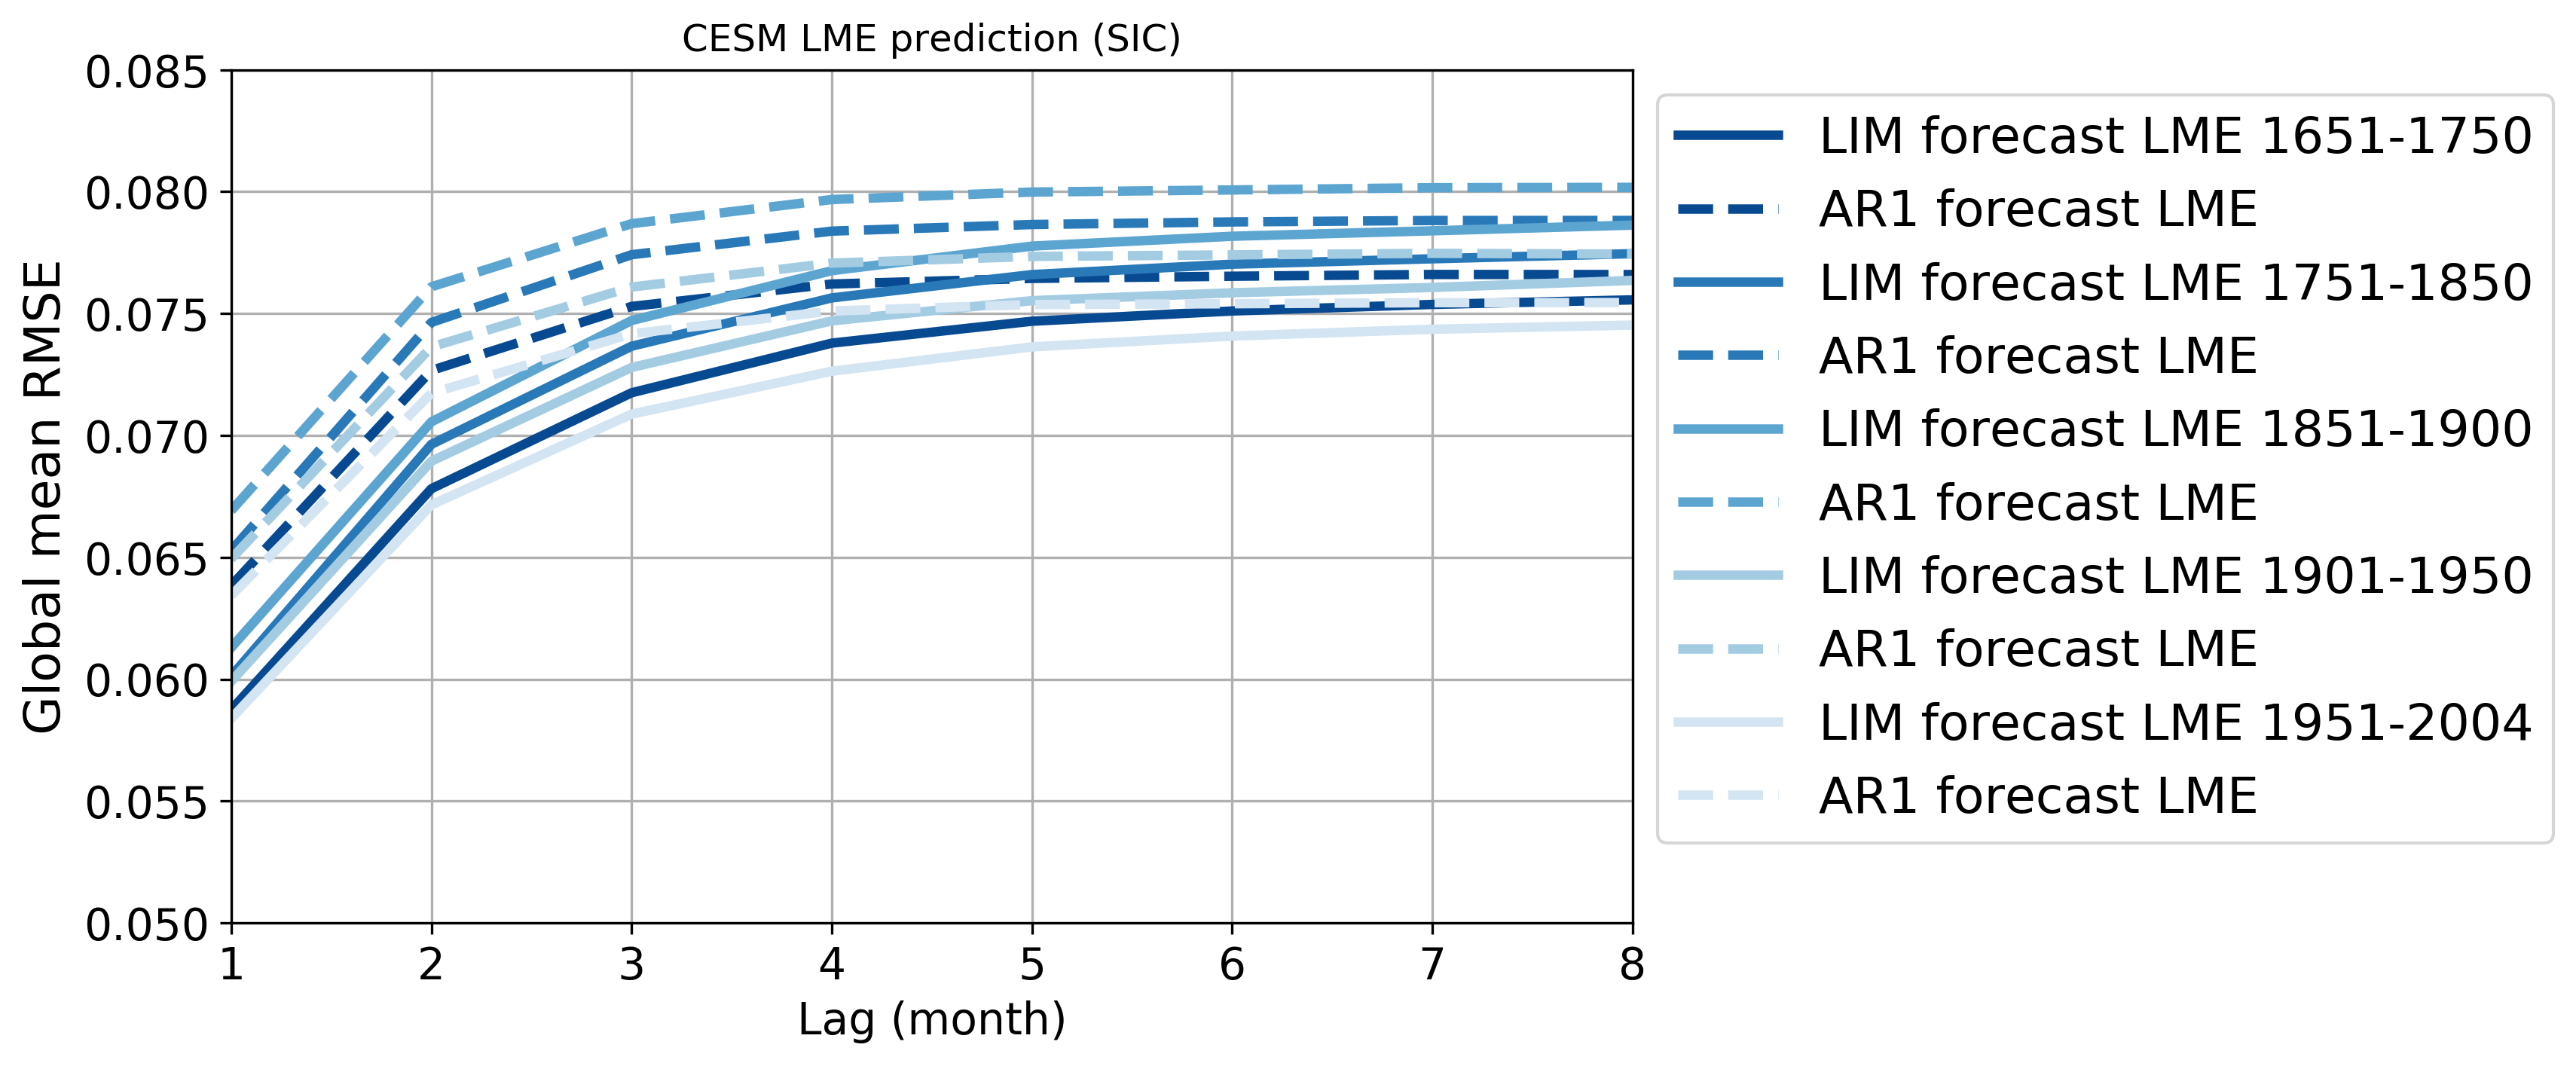

In [34]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

for i,startyr in enumerate(startyrs_list_lme):
    plt.plot(np.arange(1,9,1),gm_rmse_lme_sic[i,:], 
             label=('LIM forecast LME '+str(startyr)+'-'+str(startyr+valid_length[i])), color=colors[i], linewidth=3)
    plt.plot(np.arange(1,9,1),gm_rmse_ar1_lme_sic[i,:], 
             label='AR1 forecast LME', color=colors[i], linewidth=3, linestyle='--')

plt.ylim(0.05,0.085)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('CESM LME prediction (SIC)')

Text(0.5, 1.0, 'Sea-ice Concentration')

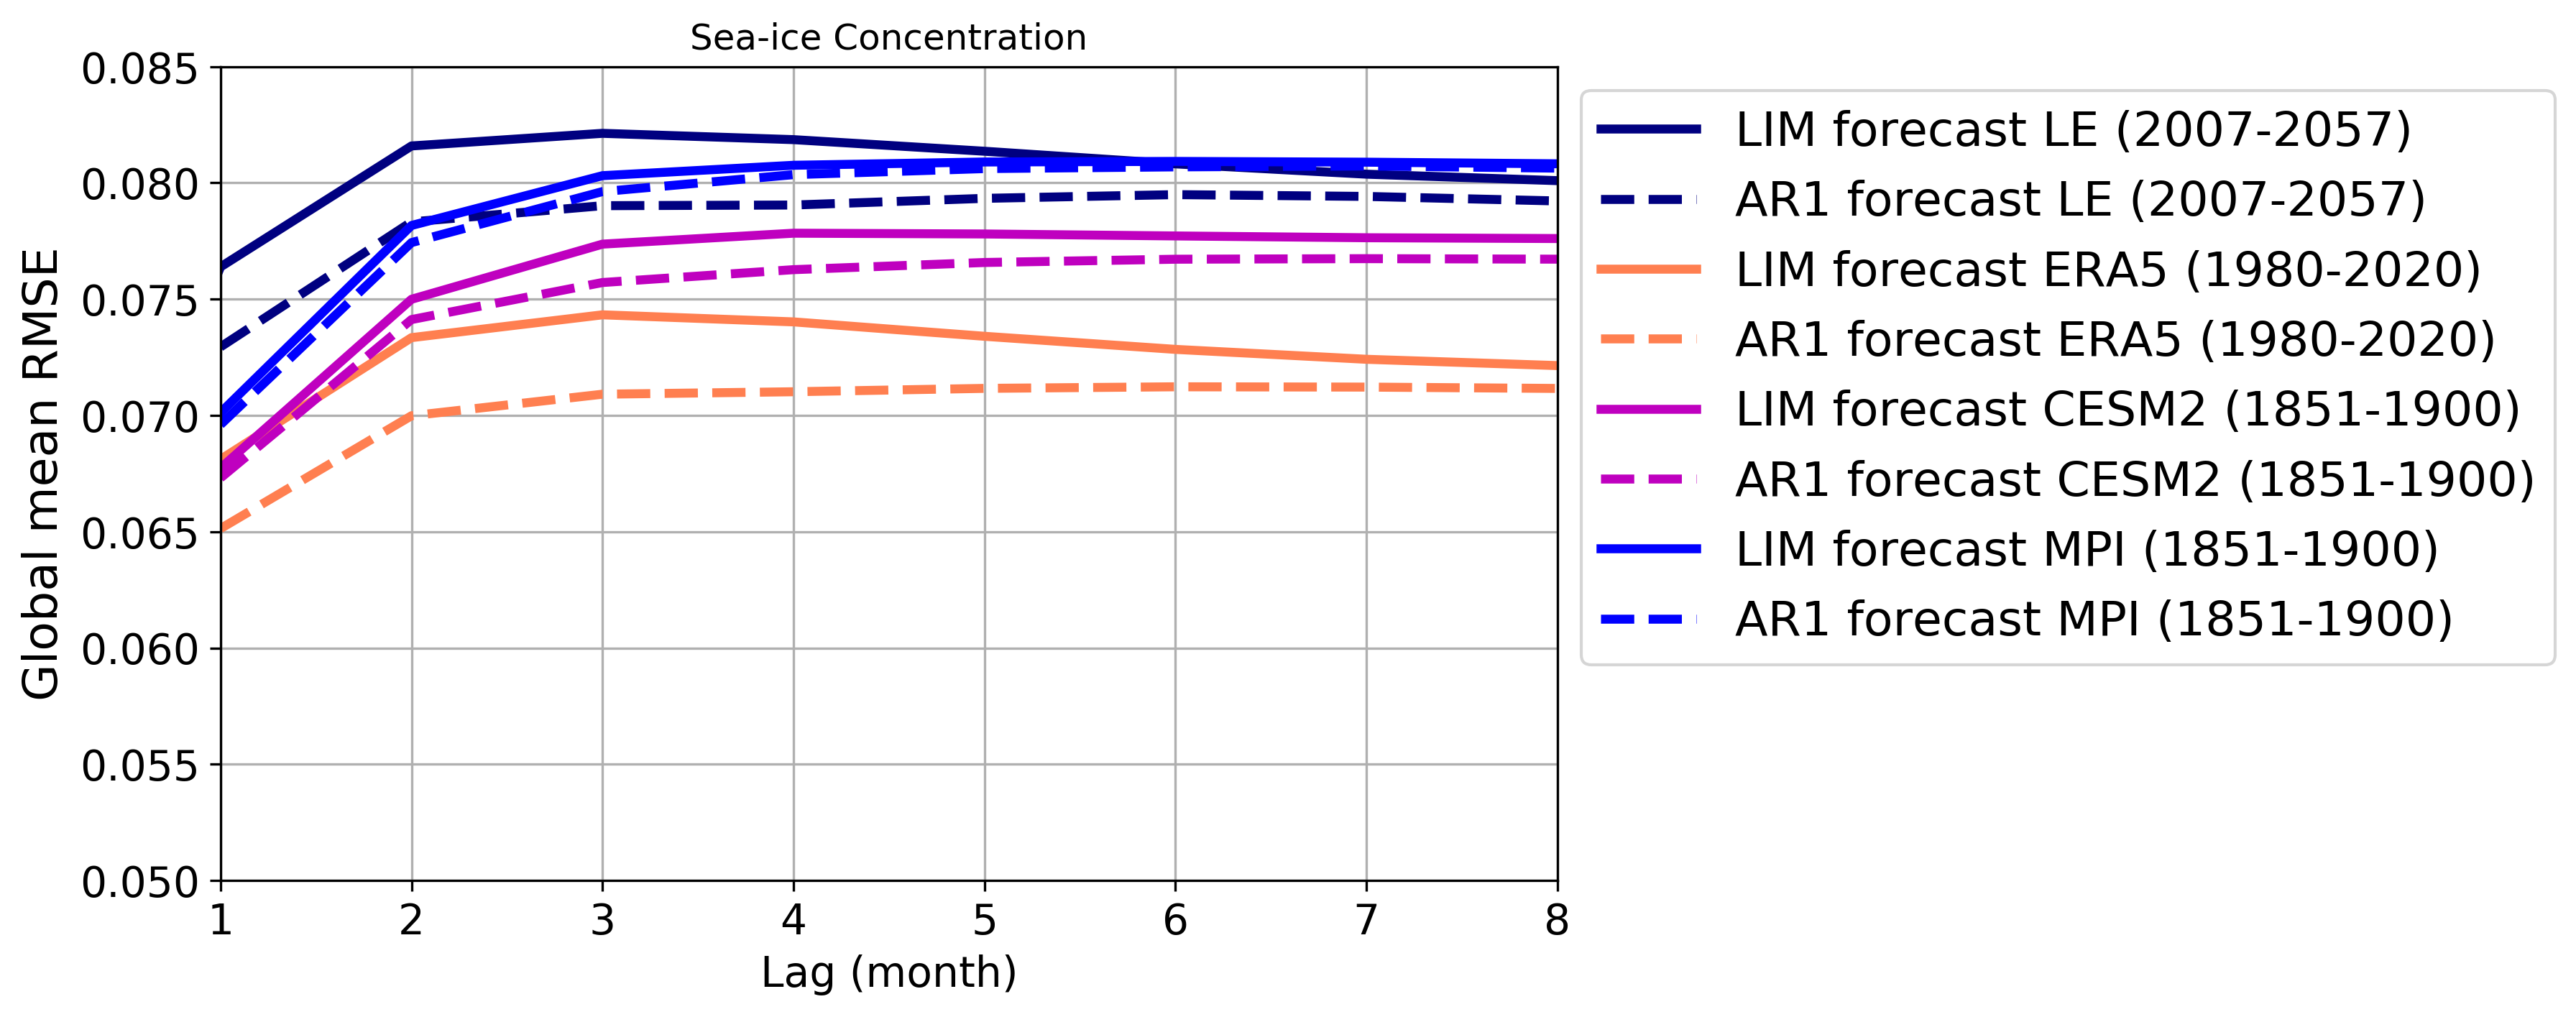

In [35]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'], 
#          label='LIM forecast LME (1851-1900)', color=colors[0], linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
#          label='AR1 forecast LME (1851-1900)', color=colors[0], linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'], 
#          label='LIM forecast LME (1901-1950)', color=colors[1], linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
#          label='AR1 forecast LME (1901-1950)', color=colors[1], linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'], 
#          label='LIM forecast LME (1951-2004)', color=colors[2], linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
#          label='AR1 forecast LME (1951-2004)', color=colors[2], linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast LE (2007-2057)', color='navy', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast LE (2007-2057)', color='navy', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_era5['validation_stats_lags'][var]['gm_rmse'], 
         label='LIM forecast ERA5 (1980-2020)', color='coral', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_era5['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
         label='AR1 forecast ERA5 (1980-2020)', color='coral', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist1['validation_stats_lags'][var]['gm_rmse'], 
         label='LIM forecast CESM2 (1851-1900)', color='m', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
         label='AR1 forecast CESM2 (1851-1900)', color='m', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_mpi_hist1['validation_stats_lags'][var]['gm_rmse'], 
         label='LIM forecast MPI (1851-1900)', color='b', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_mpi_hist1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
         label='AR1 forecast MPI (1851-1900)', color='b', linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist2['validation_stats_lags'][var]['gm_rmse'], 
#          label='LIM forecast CESM2 (1901-1950)', color='m', linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
#          label='AR1 forecast CESM2 (1901-1950)', color='m', linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist3['validation_stats_lags'][var]['gm_rmse'], 
#          label='LIM forecast CESM2 (1951-2014)', color='m', linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
#          label='AR1 forecast CESM2 (1951-2014)', color='m', linewidth=3, linestyle='--')

plt.ylim(0.05,0.085)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'CCSM4 Prediction (SIC)')

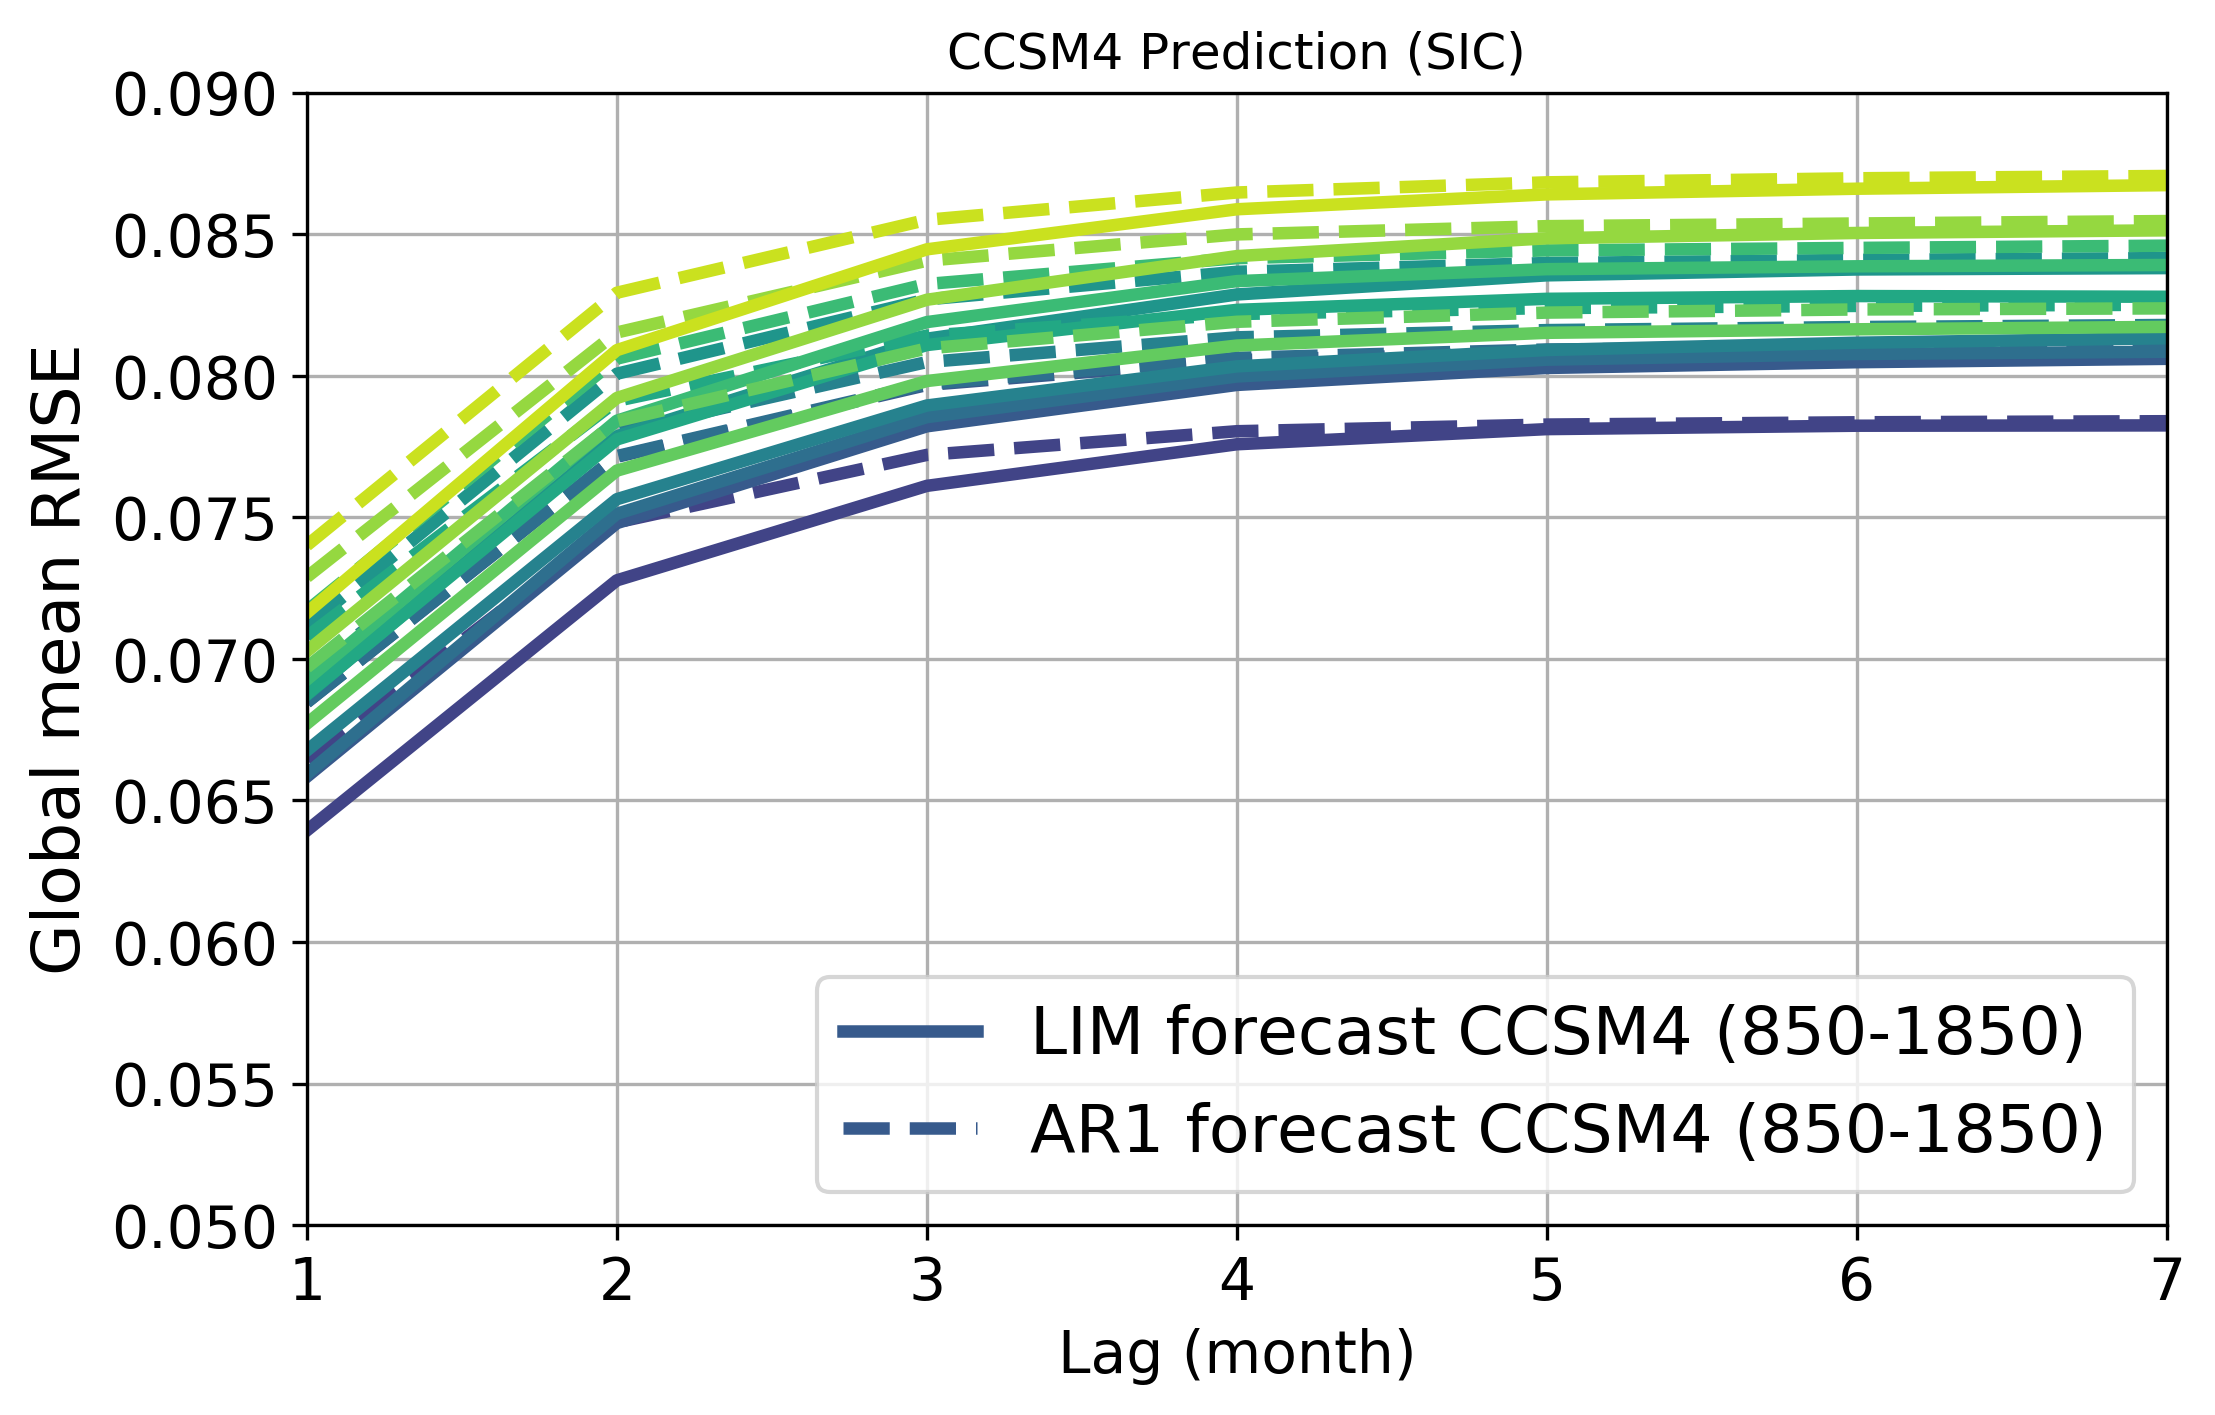

In [36]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')


for i, startyr in enumerate(startyrs_list):
    if i == 1: 
        plt.plot(np.arange(1,9,1),gm_rmse_ccsm4_sic[i,:], 
                 label='LIM forecast CCSM4 (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_ccsm4_sic[i,:], 
                 label='AR1 forecast CCSM4 (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_ccsm4_sic[i,:],  
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_ccsm4_sic[i,:], 
                 color=colors2[i], linewidth=3, linestyle='--')

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('CCSM4 Prediction (SIC)')

Text(0.5, 1.0, 'MPI Prediction (SIC)')

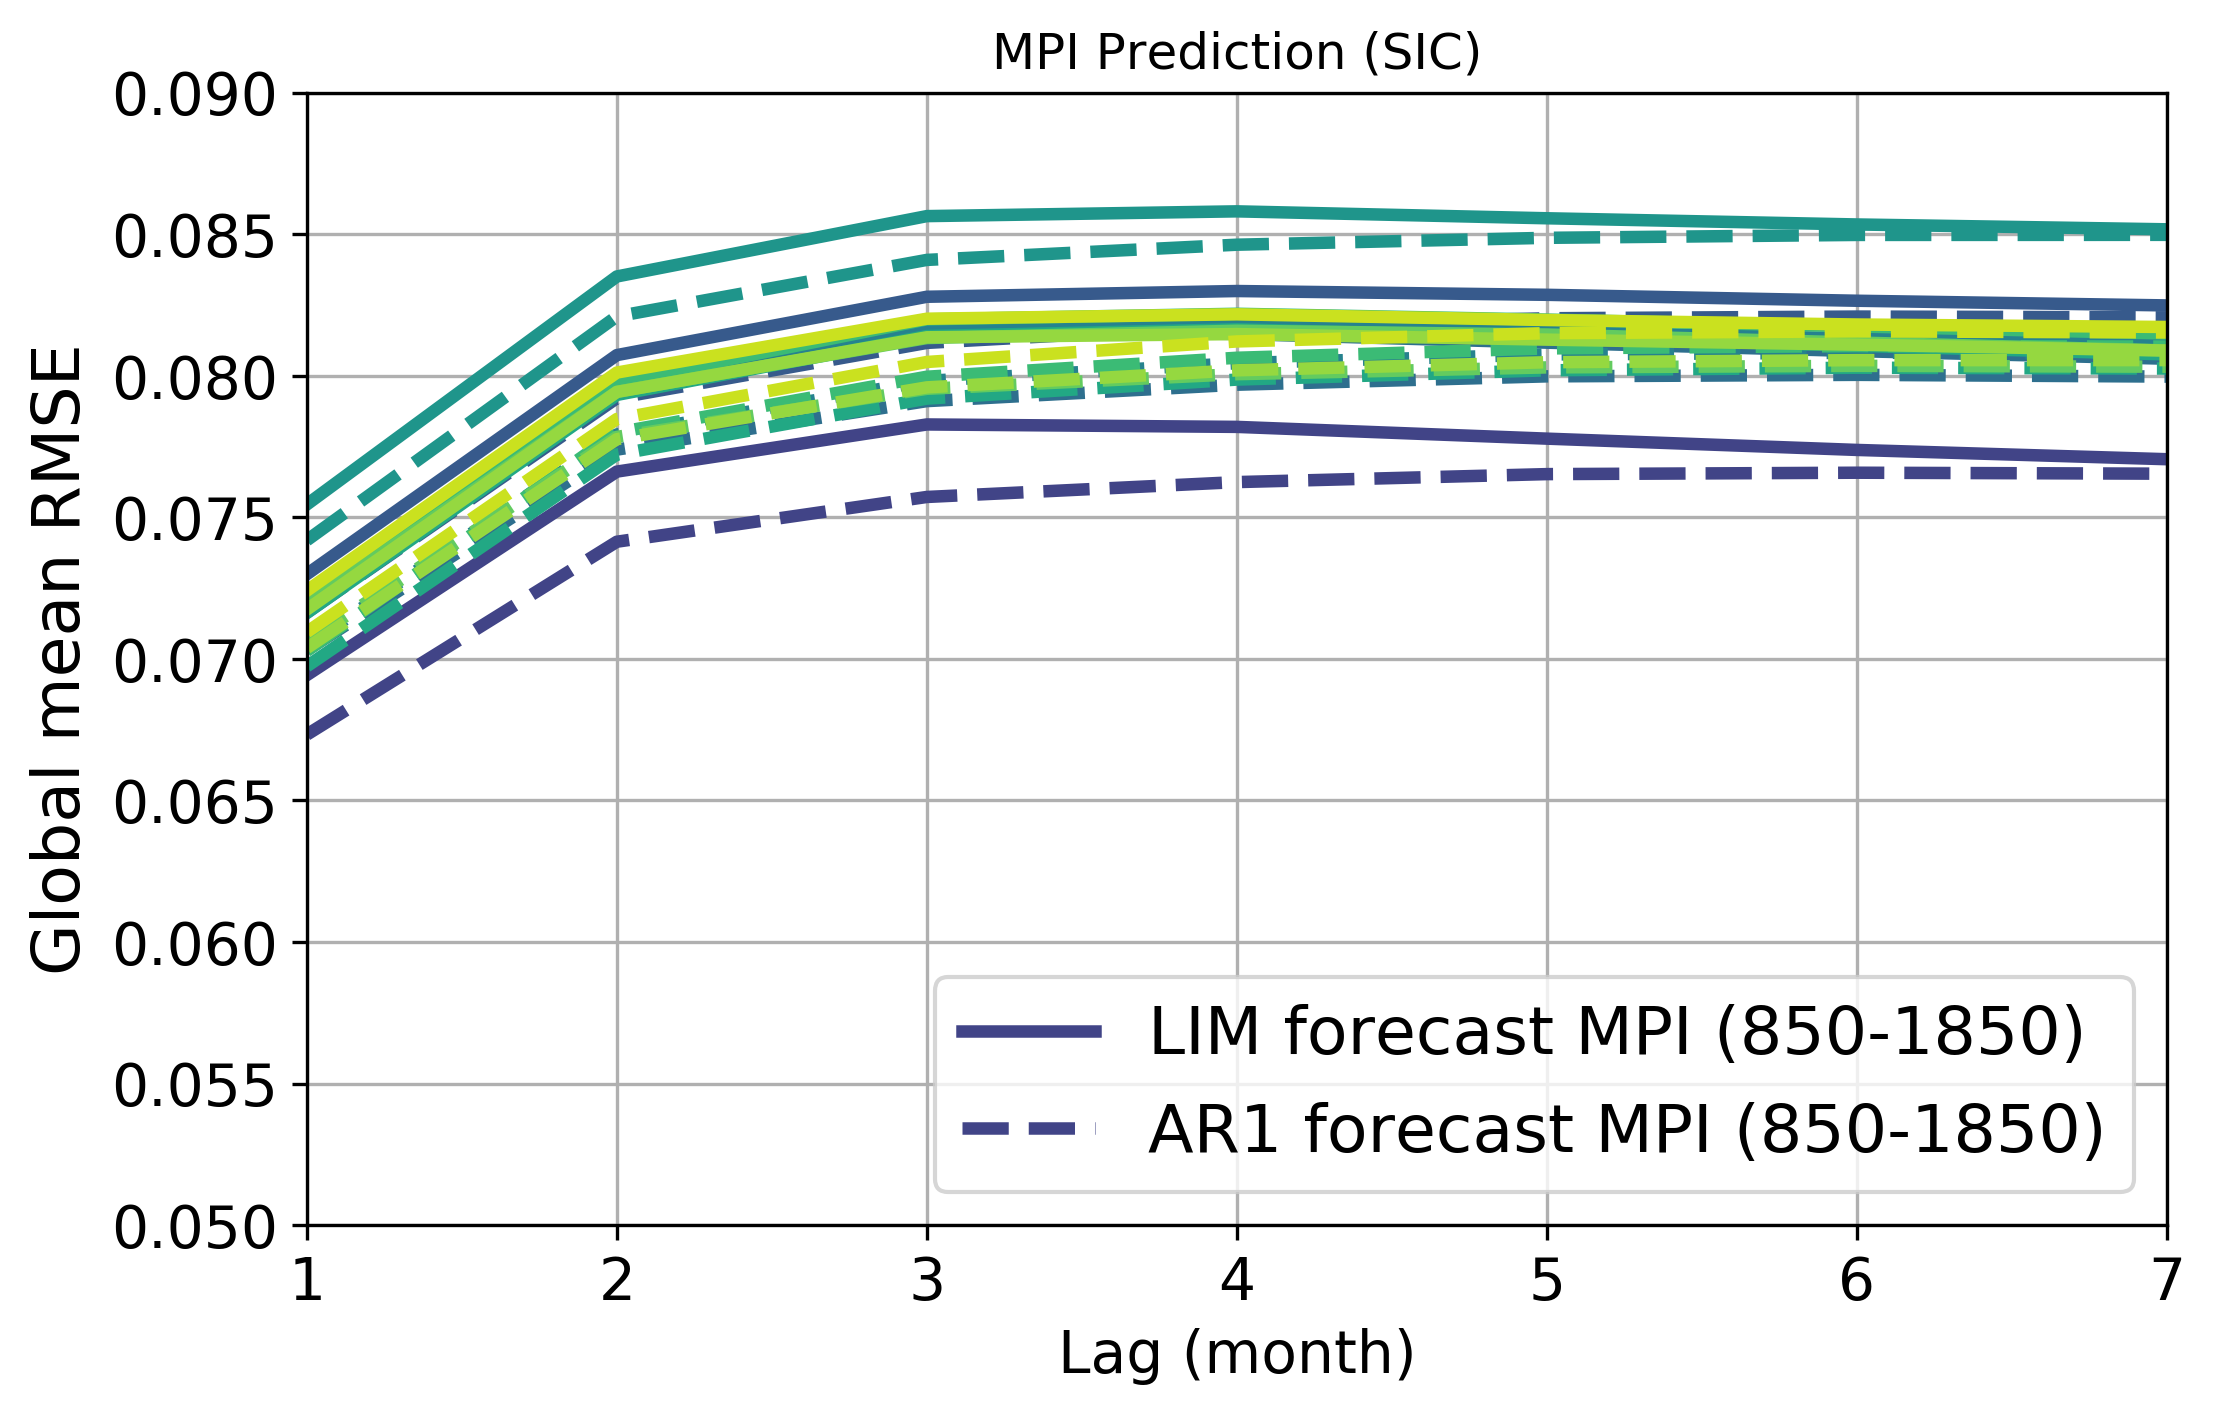

In [37]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

for i, startyr in enumerate(startyrs_list):
    if i == 0: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi_sic[i,:], 
                 label='LIM forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi_sic[i,:], 
                 label='AR1 forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi_sic[i,:], 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi_sic[i,:],  
                 color=colors2[i], linewidth=3, linestyle='--')
        

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc ='lower right',fontsize=16)
plt.title('MPI Prediction (SIC)')

Text(0.5, 1.0, 'MPI Prediction (native grid, SIC)')

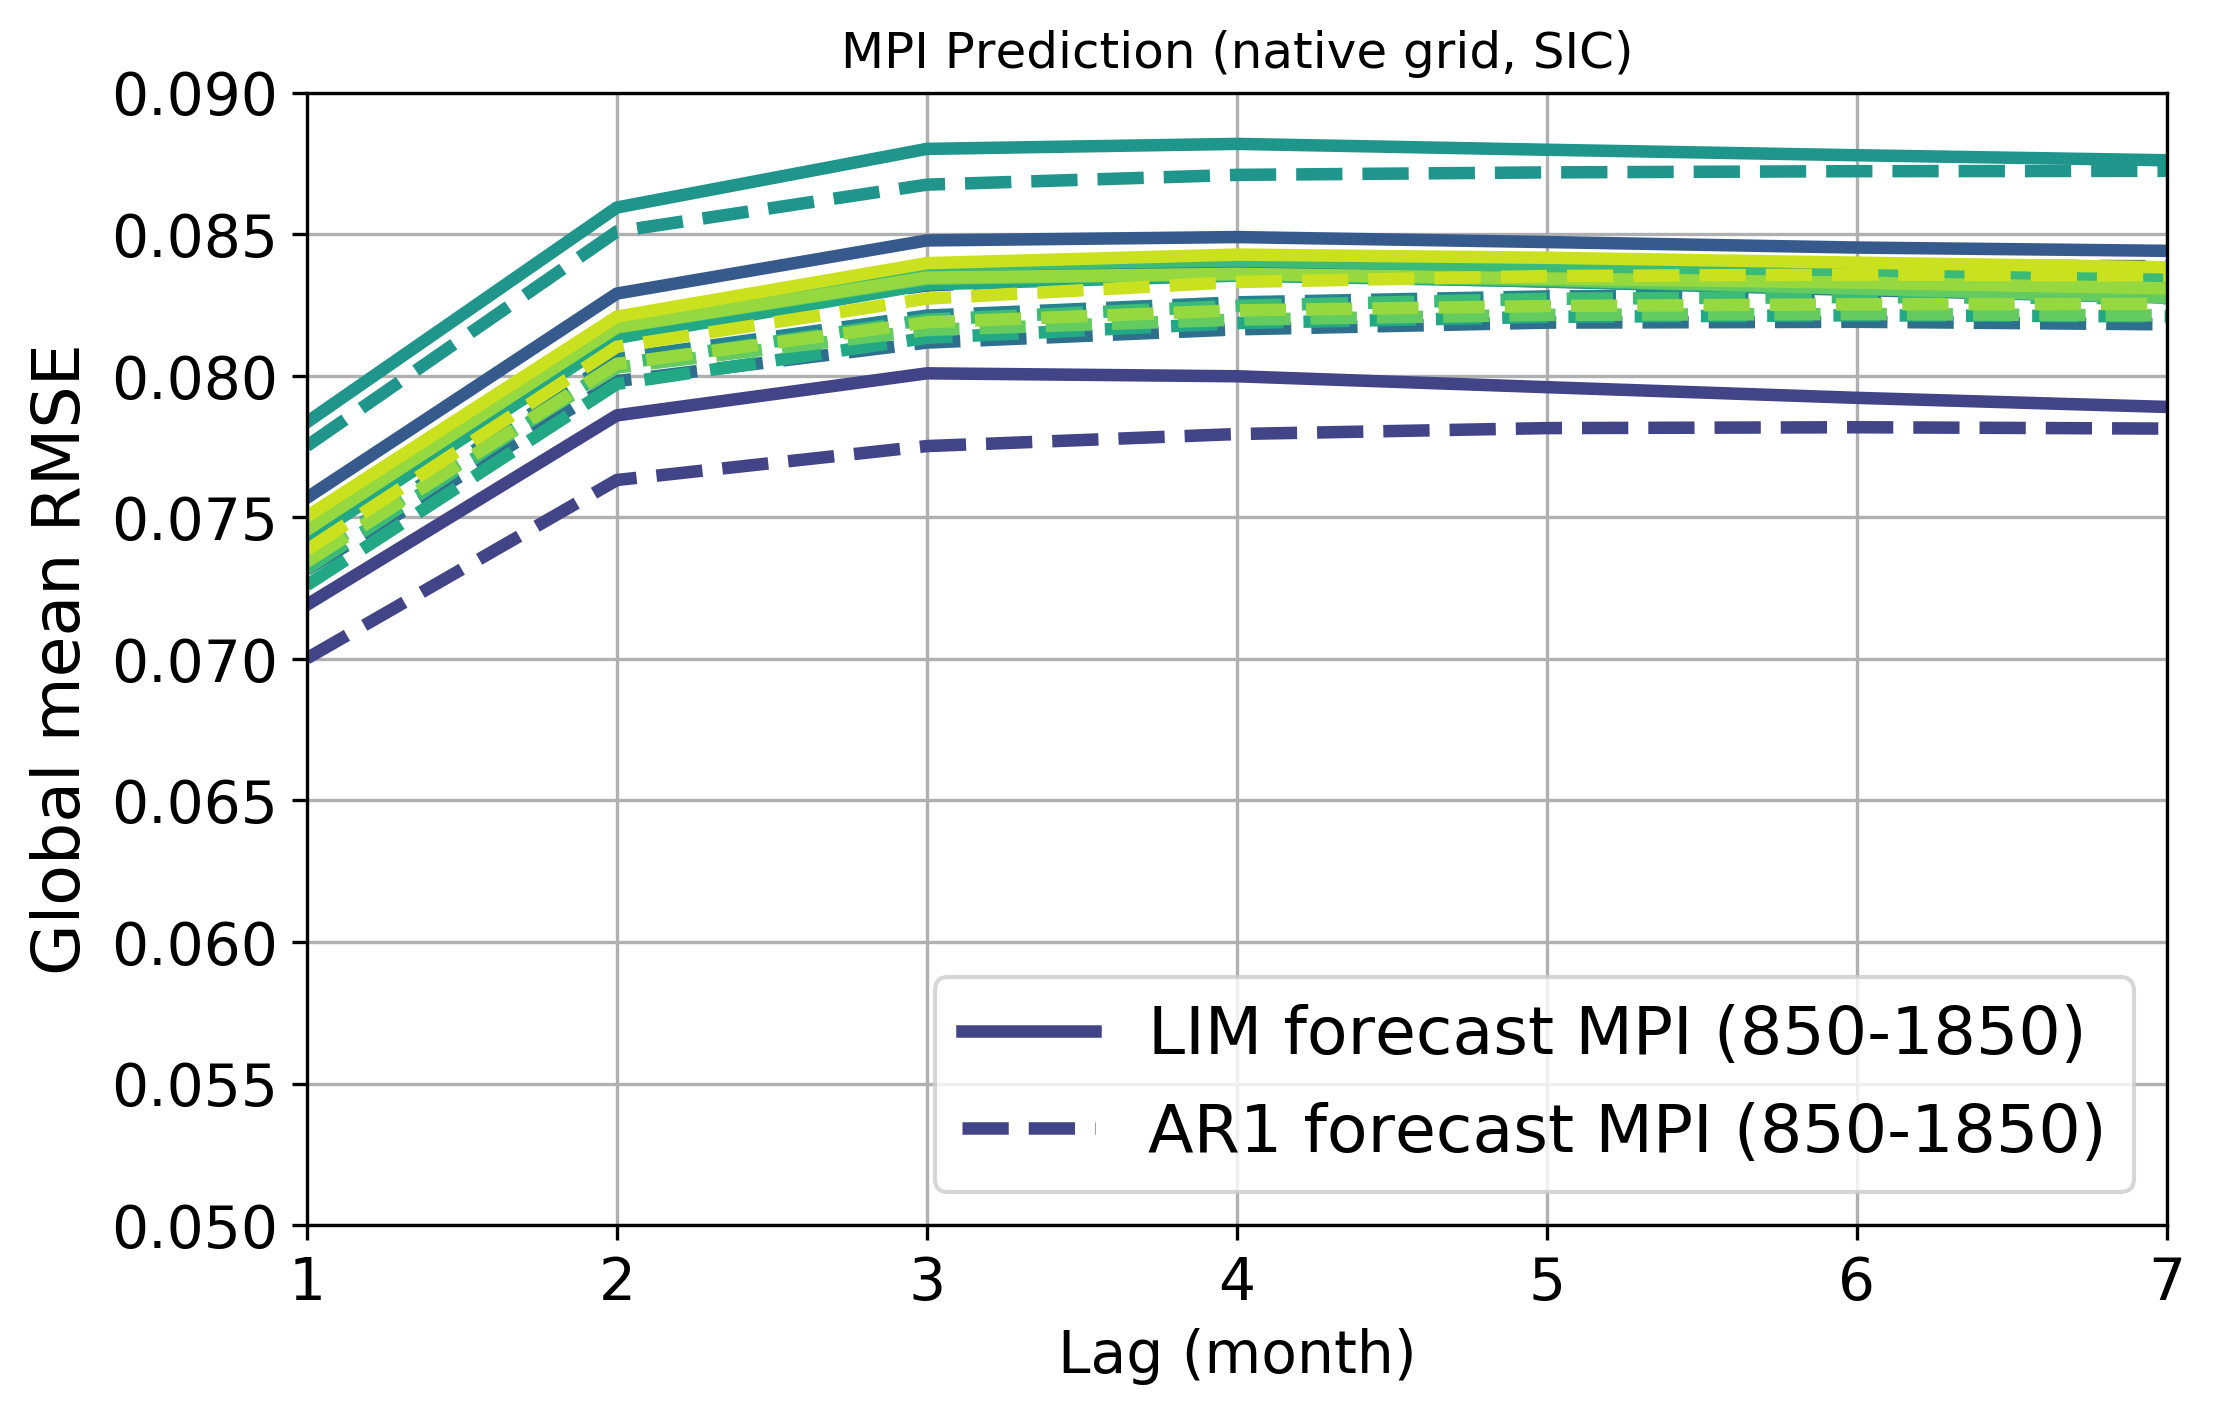

In [38]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

for i, startyr in enumerate(startyrs_list):
    if i == 0: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi2_sic[i,:], 
                 label='LIM forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi2_sic[i,:], 
                 label='AR1 forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi2_sic[i,:], 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi2_sic[i,:],  
                 color=colors2[i], linewidth=3, linestyle='--')
        

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc ='lower right',fontsize=16)
plt.title('MPI Prediction (native grid, SIC)')

In [39]:
#filename = 'Spatial_correlation_sic_meanstates_CESMlme_ERA5_CESMle.pkl'
#filename = 'Spatial_correlation_sic_variance_CESMlme_ERA5_CESMle_CESM2_GFDL.pkl'
#filename = 'Spatial_correlation_sic_meanstates_CESMlme_ERA5_CESMle_CESM2_GFDL.pkl'
filename = 'Spatial_correlation_sic_variance_CESMlme_ERA5_CESMle_CESM2_GFDL_MPI_LM_031922.pkl'
scorr = pickle.load( open( filename, "rb" ) )

In [40]:
scorr.keys()

dict_keys(['scor_train_le', 'scor_train_era5', 'scor_train_sat', 'scor_lme3_sat', 'scor_le_sat', 'scor_cesm2_sat', 'scor_gfdl_sat', 'scor_mpi_sat', 'scor_mpilm_sat', 'scor_ccsm4lm_sat', 'scor_train_mpi_lm', 'scor_train_mpi_lm_all', 'scor_train_ccsm4_lm', 'scor_train_ccsm4_lm_all', 'scor_train_lme1', 'scor_train_lme2', 'scor_train_lme3', 'scor_train_cesm2_hist1', 'scor_train_cesm2_hist2', 'scor_train_cesm2_hist3', 'scor_train_cesm2_hist', 'scor_train_gfdl_hist1', 'scor_train_gfdl_hist2', 'scor_train_gfdl_hist3', 'scor_train_gfdl_hist', 'scor_train_mpi_hist1', 'scor_train_mpi_hist2', 'scor_train_mpi_hist3', 'scor_train_mpi_hist', 'scor_train_canESM_hist1', 'scor_train_canESM_hist2', 'scor_train_canESM_hist3', 'scor_train_canESM_hist', 'scor_train_hadGEM3_hist1', 'scor_train_hadGEM3_hist2', 'scor_train_hadGEM3_hist3', 'scor_train_hadGEM3_hist'])

In [52]:
diff_le = -ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1]
diff_era5 = -ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1]

diff_cesm2_hist1 = -ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist2 = -ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist3 = -ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_gfdl_hist1 = -ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist2 = -ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist3 = -ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_mpi_hist1 = -ar1cast_lags_mpi_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_mpi_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_mpi_hist2 = -ar1cast_lags_mpi_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_mpi_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_mpi_hist3 = -ar1cast_lags_mpi_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] + forecast_validation_lags_mpi_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

In [59]:
diff_lme = np.zeros(len(startyrs_list_lme))
for i,startyr in enumerate(startyrs_list_lme):
    diff_lme[i] = -gm_rmse_ar1_lme_sic[i,0] + gm_rmse_lme_sic[i,0] 

In [60]:
diff_ccsm4 = np.zeros(len(startyrs_list))
diff_mpi = np.zeros(len(startyrs_list))
for i,startyr in enumerate(startyrs_list):
    diff_ccsm4[i] = -gm_rmse_ar1_ccsm4_sic[i,0] + gm_rmse_ccsm4_sic[i,0] 
    diff_mpi[i] = -gm_rmse_ar1_mpi_sic[i,0] + gm_rmse_mpi_sic[i,0] 

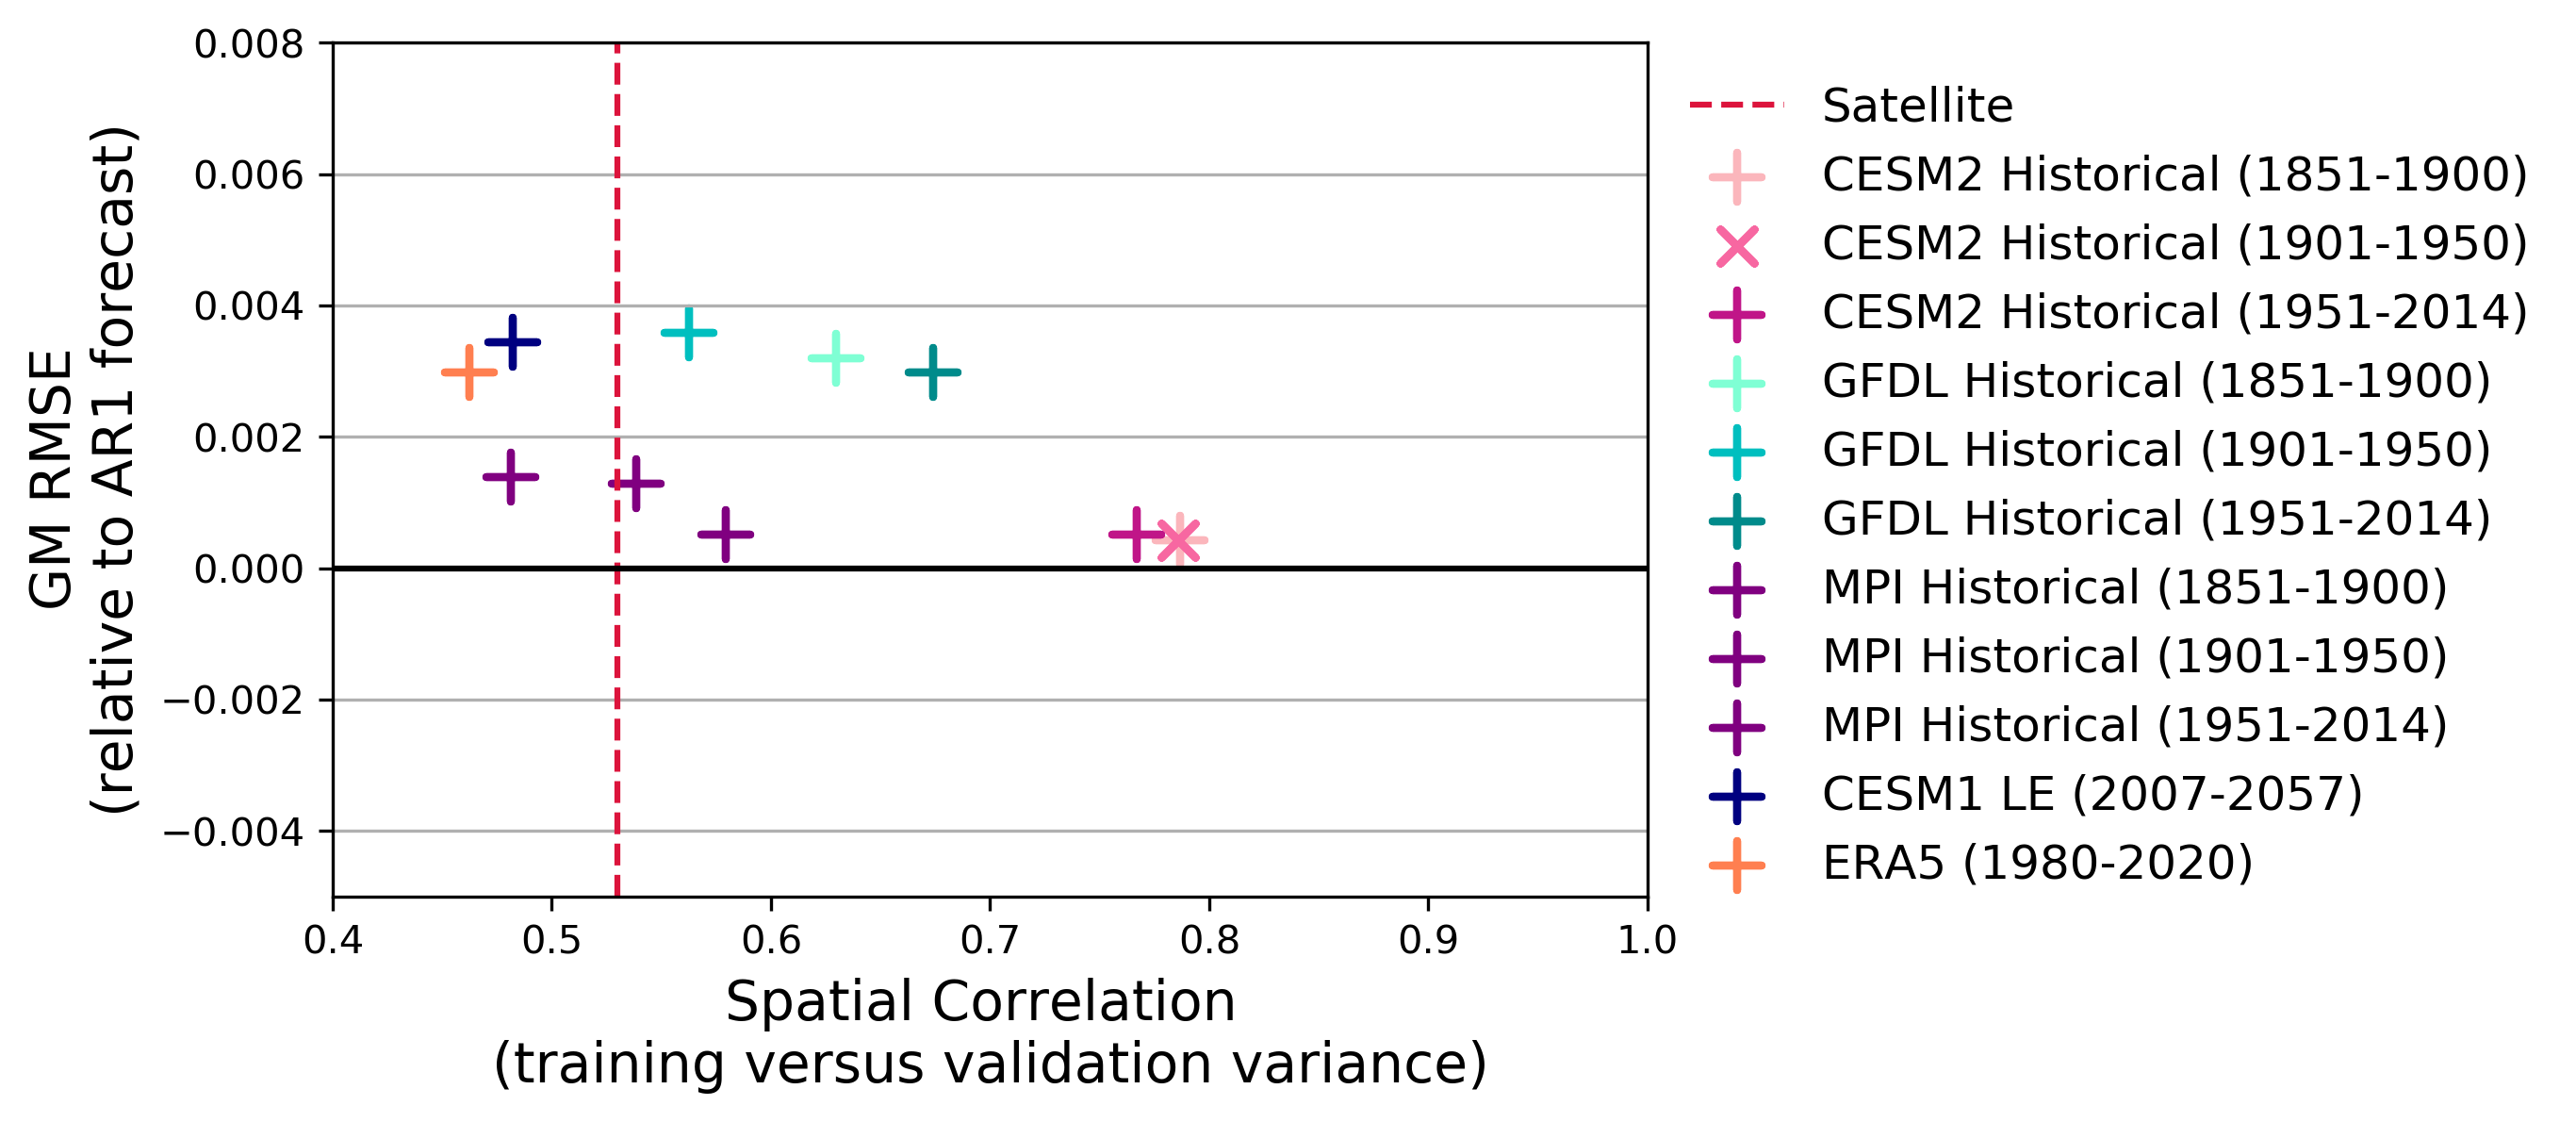

In [61]:
fig = plt.figure(figsize=(6,4))

# plt.scatter(scorr['scor_train_lme1'],diff_lme[2], color=colors[0],marker=(4,2,0),s=150,
#             linewidth=2,label='CESM1 LME (1851-1900)')
# plt.scatter(scorr['scor_train_lme2'],diff_lme[3], color=colors[1],marker=(4,2,0),s=150,
#             linewidth=2,label='CESM1 LME (1901-1950)')
# plt.scatter(scorr['scor_train_lme3'],diff_lme[4], color=colors[2],marker=(4,2,0),s=150,
#             linewidth=2,label='CESM1 LME (1951-2004)')

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1,color=colors1[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-1900)')
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2, color=colors1[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM2 Historical (1901-1950)')
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3, color=colors1[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1951-2014)')

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1,color='aquamarine',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-1900)')
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1901-1950)')
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3, color='darkcyan',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1951-2014)')

plt.scatter(scorr['scor_train_mpi_hist1'],diff_mpi_hist1,color='purple',marker=(4,2,0),s=150,
            linewidth=2,label='MPI Historical (1851-1900)')
plt.scatter(scorr['scor_train_mpi_hist2'],diff_mpi_hist2, color='purple',marker=(4,2,0),s=150,
            linewidth=2,label='MPI Historical (1901-1950)')
plt.scatter(scorr['scor_train_mpi_hist3'],diff_mpi_hist3, color='purple',marker=(4,2,0),s=150,
            linewidth=2,label='MPI Historical (1951-2014)')

plt.scatter(scorr['scor_train_le'],diff_le, color='navy',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057)')
plt.scatter(scorr['scor_train_era5'],diff_era5, color='coral',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)')

plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE \n(relative to AR1 forecast)', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(-0.005,0.008)
plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)
plt.grid(axis='y')

plt.axhline(0,color='k')

In [62]:
# diff_lme1 = ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1]
# diff_lme2 = ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1]

# diff_ccsm4 = np.zeros(len(startyrs_list))
# diff_mpi = np.zeros(len(startyrs_list))
# for i,startyr in enumerate(startyrs_list):
#     diff_ccsm4[i] = gm_rmse_ar1_ccsm4_sic[i,0] - gm_rmse_ccsm4_sic[i,0] 
#     diff_mpi[i] = gm_rmse_ar1_mpi_sic[i,0] - gm_rmse_mpi_sic[i,0] 

In [63]:
diff_lme

array([-0.00509642, -0.00515554, -0.00561988, -0.00503007, -0.0050497 ])

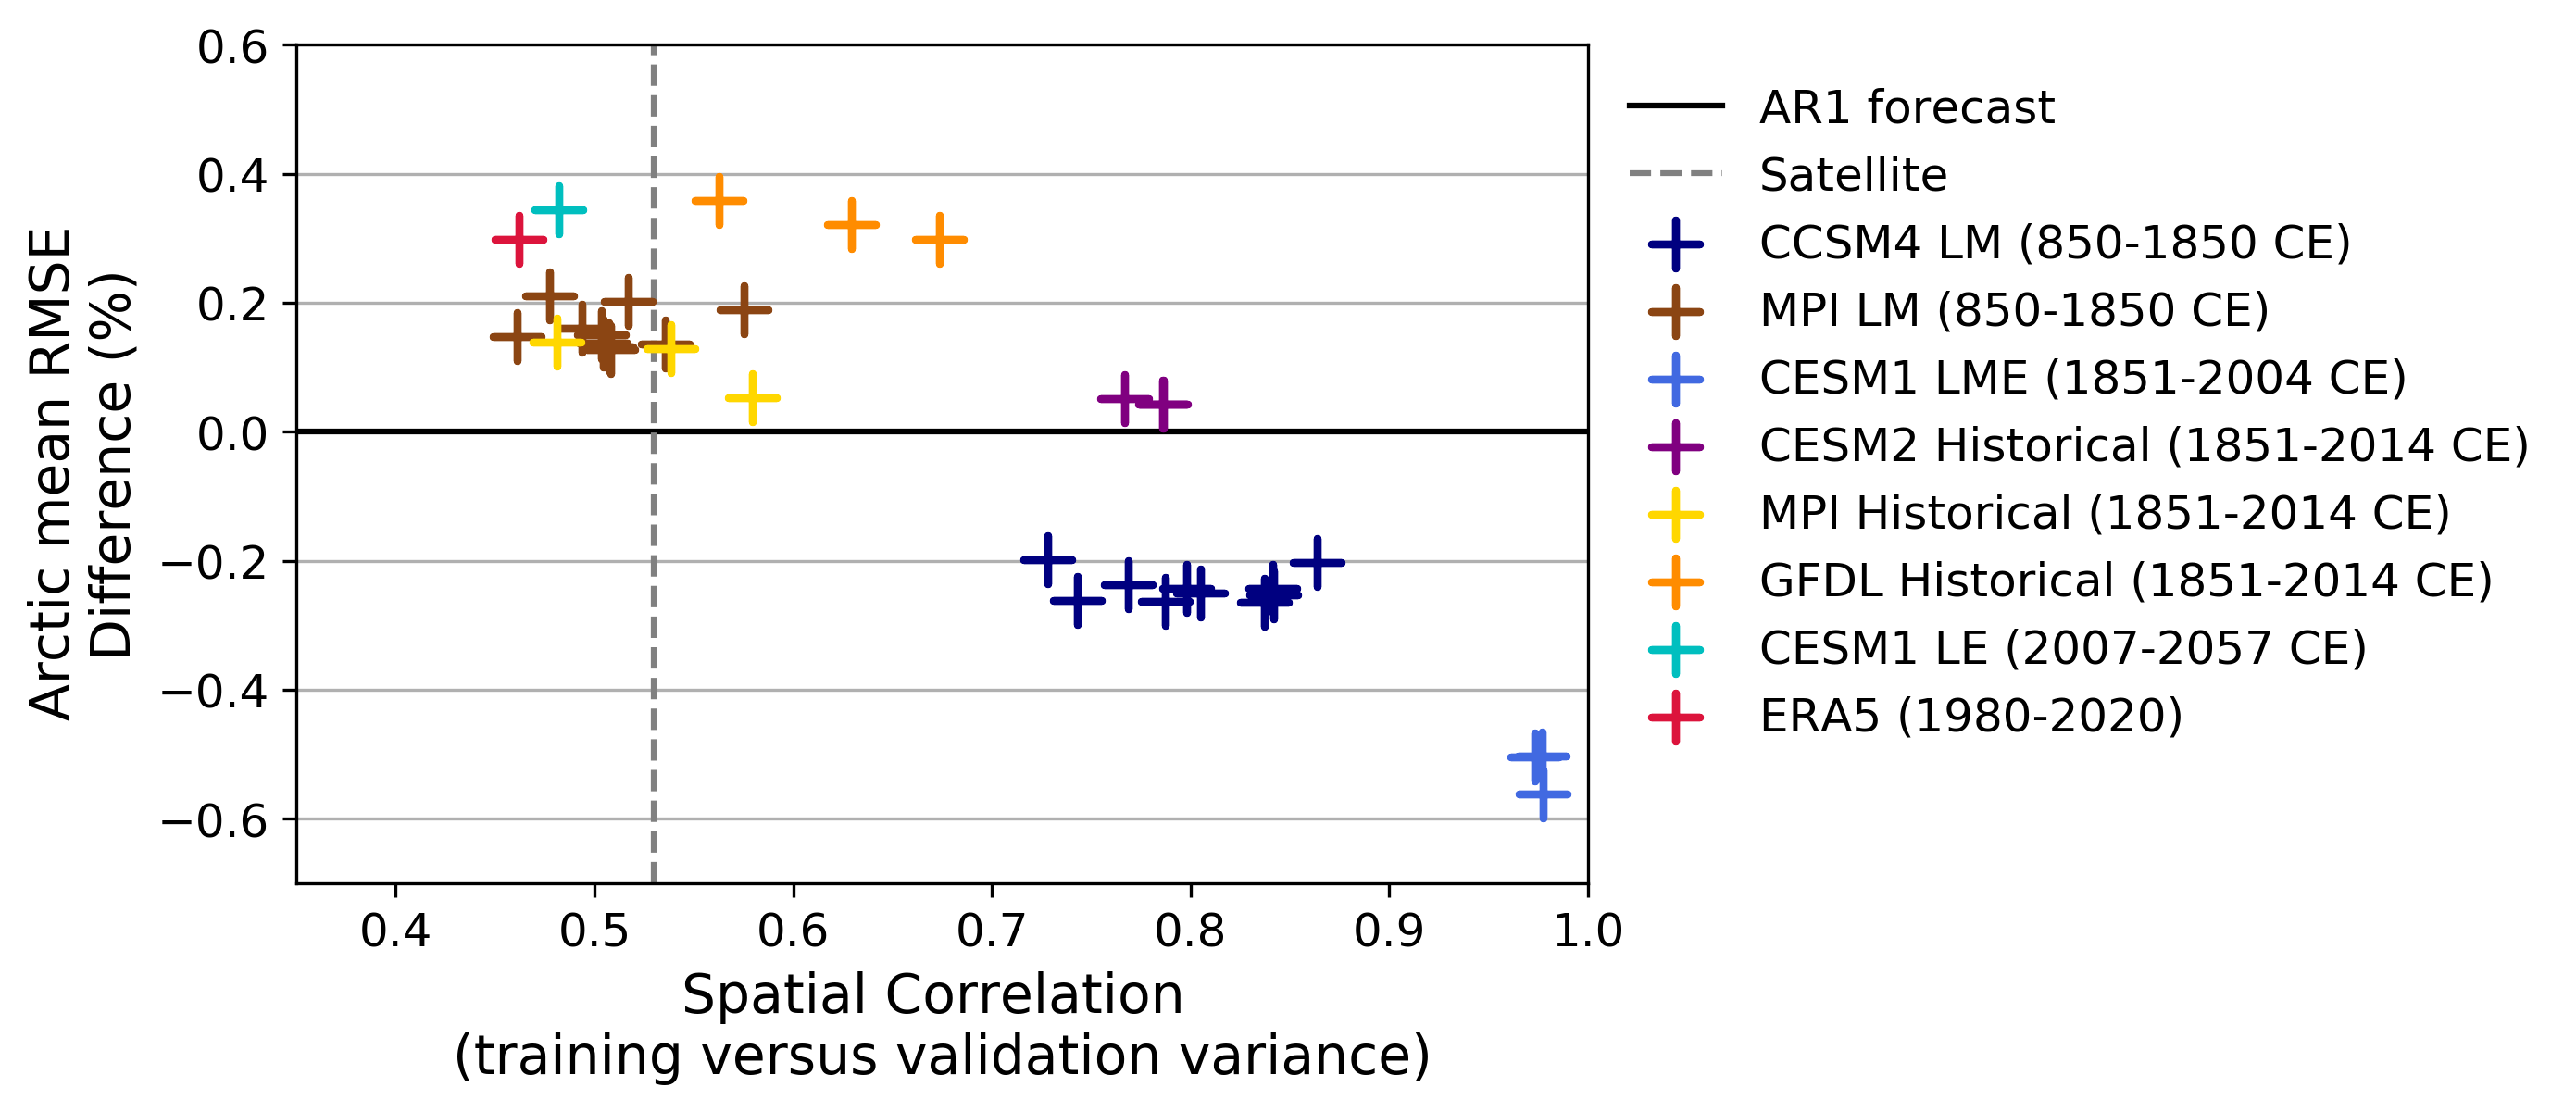

In [65]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

plt.grid(axis='y',zorder=0)

for i,startyr in enumerate(startyrs_list):
    if i ==0:
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i]*100, color='navy',marker=(4,2,0),s=150, 
                    linewidth=2, label='CCSM4 LM (850-1850 CE)',zorder=10)
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i]*100, color='saddlebrown',marker=(4,2,0),s=150, 
                    linewidth=2, label='MPI LM (850-1850 CE)',zorder=10)
    else: 
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i]*100, color='navy',marker=(4,2,0),s=150, 
                    linewidth=2,zorder=10)
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i]*100, color='saddlebrown',marker=(4,2,0),s=150, 
                    linewidth=2,zorder=10)
        
plt.scatter(scorr['scor_train_lme1'],diff_lme[2]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1851-2004 CE)',zorder=10)
plt.scatter(scorr['scor_train_lme2'],diff_lme[3]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_lme3'],diff_lme[4]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1*100,color='purple',marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2*100, color='purple',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3*100, color='purple',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_mpi_hist1'],diff_mpi_hist1*100,color='gold',marker=(4,2,0),s=150,
            linewidth=2,label='MPI Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_mpi_hist2'],diff_mpi_hist2*100, color='gold',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_mpi_hist3'],diff_mpi_hist3*100, color='gold',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1*100,color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2*100, color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3*100, color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_le'],diff_le*100, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057 CE)',zorder=10)
plt.scatter(scorr['scor_train_era5'],diff_era5*100, color='crimson',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)',zorder=10)

plt.axhline(0,color='k', label='AR1 forecast')

plt.axvline(scorr['scor_train_sat'], color='gray', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('Arctic mean RMSE \nDifference (%)', fontsize=14)

plt.xlim(0.35,1.0)
plt.ylim(-0.7,0.6)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)

savename = './figures/LIM_skill_cross_model.png'
plt.savefig(savename, bbox_inches='tight')

In [48]:
x = []
y = []



for i,startyr in enumerate(startyrs_list):
    x.append(scorr['scor_train_ccsm4_lm_all'][startyr-850])
    x.append(scorr['scor_train_mpi_lm_all'][startyr-850])
    y.append(diff_ccsm4[i]*100)
    y.append(diff_mpi[i]*100)

In [49]:
x.append(scorr['scor_train_lme1'])
x.append(scorr['scor_train_lme2'])
x.append(scorr['scor_train_lme3'])
x.append(scorr['scor_train_cesm2_hist1'])
x.append(scorr['scor_train_cesm2_hist2'])
x.append(scorr['scor_train_cesm2_hist3'])
x.append(scorr['scor_train_mpi_hist1'])
x.append(scorr['scor_train_mpi_hist2'])
x.append(scorr['scor_train_mpi_hist3'])
x.append(scorr['scor_train_gfdl_hist1'])
x.append(scorr['scor_train_gfdl_hist2'])
x.append(scorr['scor_train_gfdl_hist3'])
x.append(scorr['scor_train_le'])
x.append(scorr['scor_train_era5'])

y.append(diff_lme[2]*100)
y.append(diff_lme[3]*100)
y.append(diff_lme[4]*100)
y.append(diff_cesm2_hist1*100)
y.append(diff_cesm2_hist2*100)
y.append(diff_cesm2_hist3*100)
y.append(diff_mpi_hist1*100)
y.append(diff_mpi_hist2*100)
y.append(diff_mpi_hist3*100)
y.append(diff_gfdl_hist1*100)
y.append(diff_gfdl_hist2*100)
y.append(diff_gfdl_hist3*100)
y.append(diff_le*100)
y.append(diff_era5*100)

In [50]:
[slope,intercept,rvalue,pvalue,stderr] = spy.stats.linregress(x,y)
slope,intercept,rvalue**2

(1.3583519843913936, -0.9001845138750664, 0.7659268750973104)

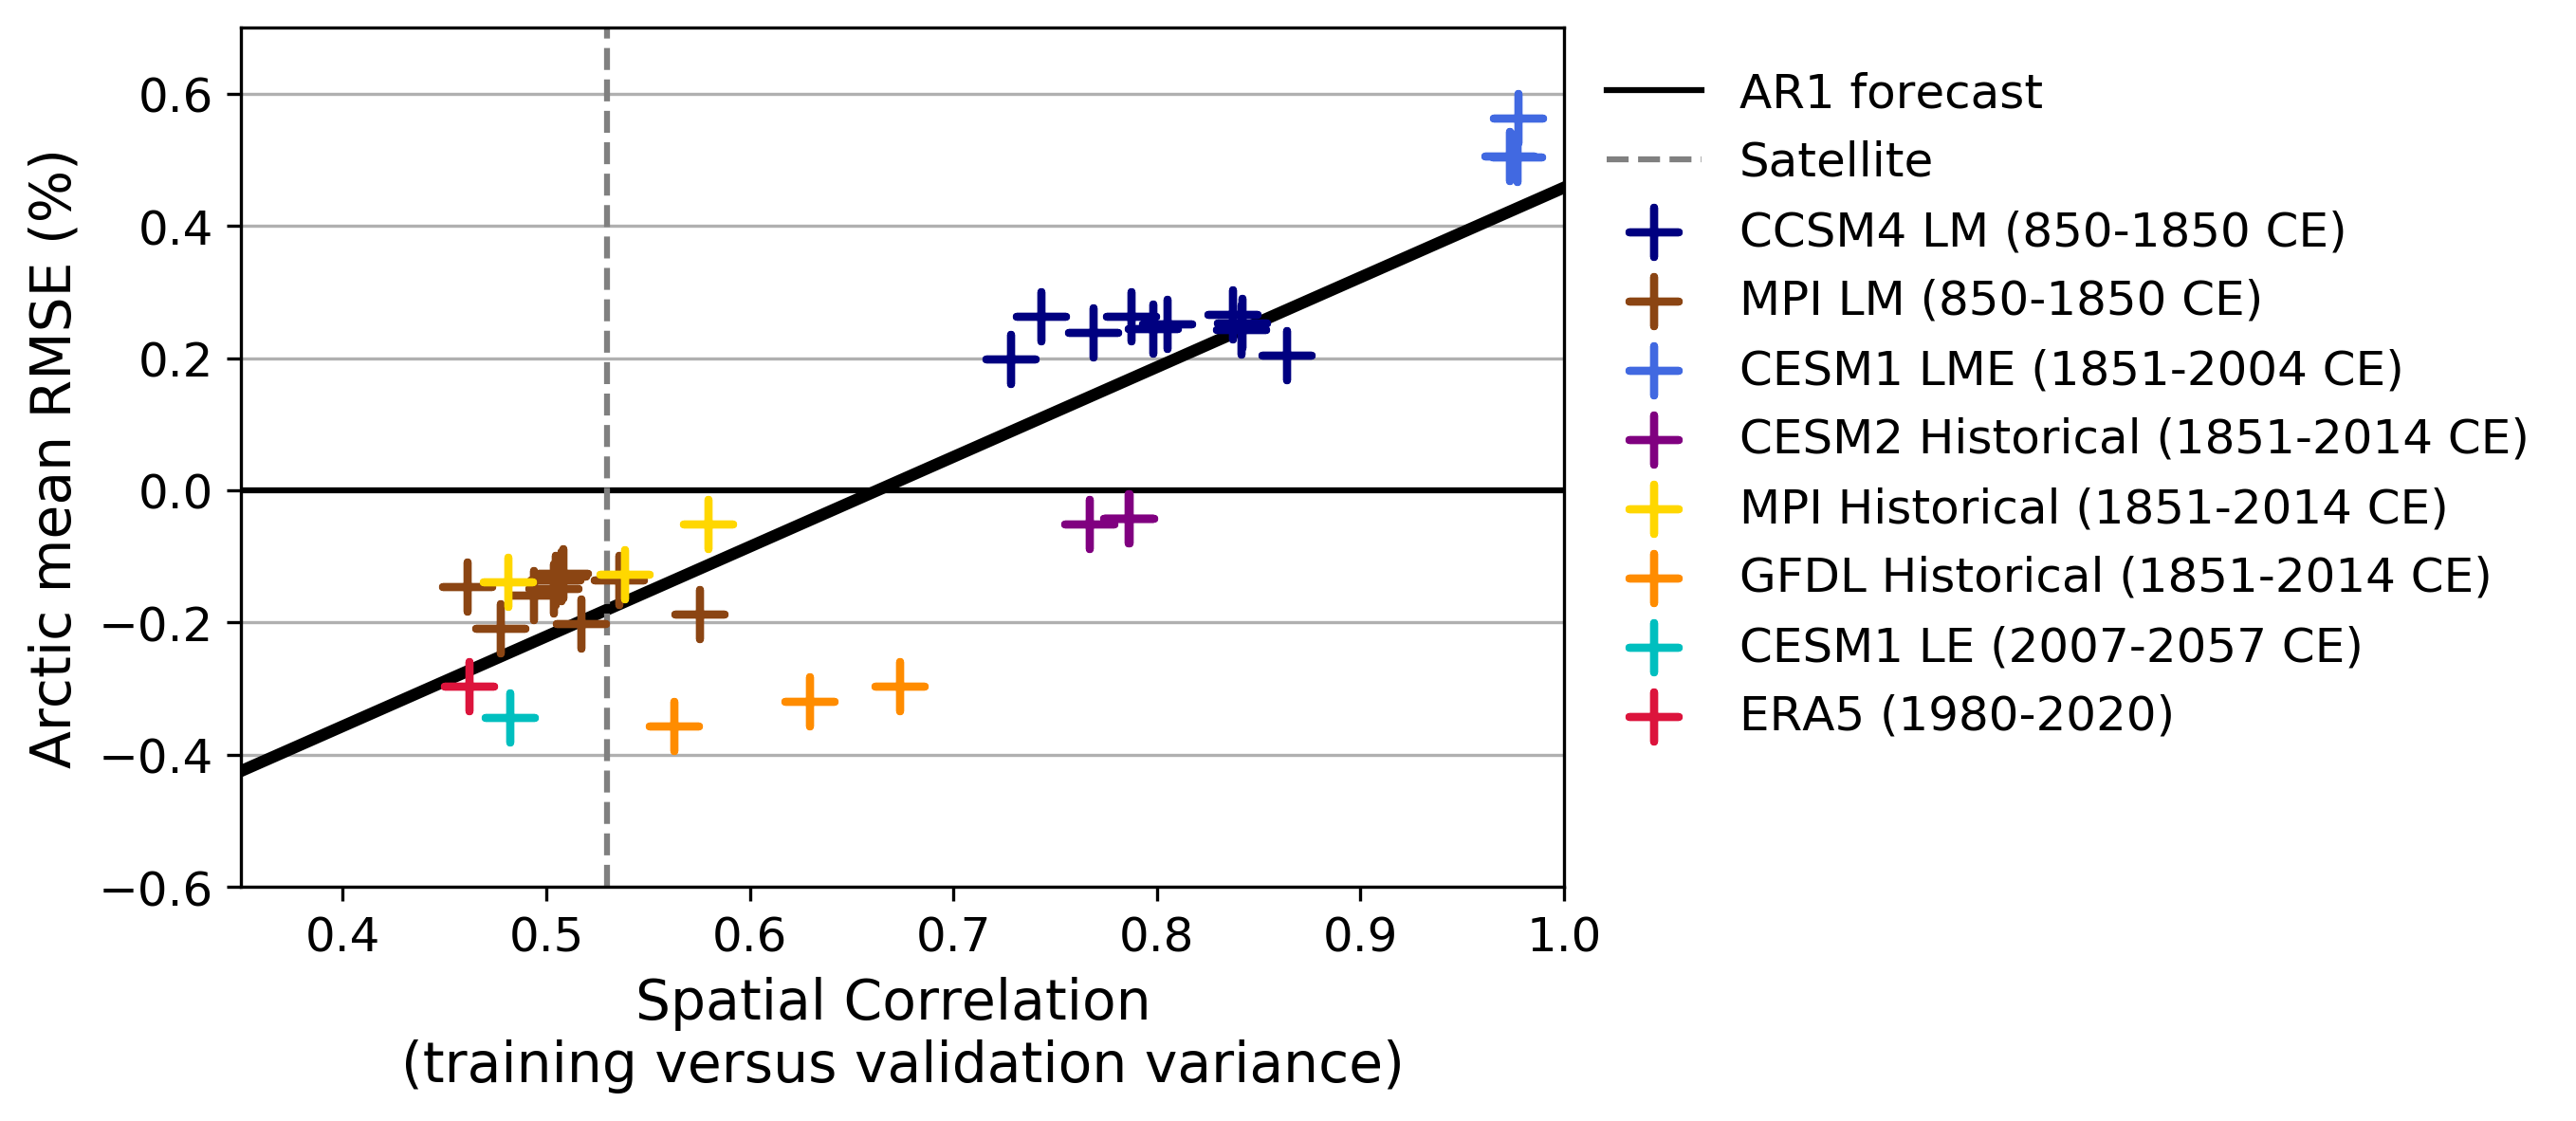

In [51]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

plt.grid(axis='y',zorder=0)

for i,startyr in enumerate(startyrs_list):
    if i ==0:
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i]*100, color='navy',marker=(4,2,0),s=150, 
                    linewidth=2, label='CCSM4 LM (850-1850 CE)',zorder=10)
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i]*100, color='saddlebrown',marker=(4,2,0),s=150, 
                    linewidth=2, label='MPI LM (850-1850 CE)',zorder=10)
    else: 
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i]*100, color='navy',marker=(4,2,0),s=150, 
                    linewidth=2,zorder=10)
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i]*100, color='saddlebrown',marker=(4,2,0),s=150, 
                    linewidth=2,zorder=10)
        
plt.scatter(scorr['scor_train_lme1'],diff_lme[2]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1851-2004 CE)',zorder=10)
plt.scatter(scorr['scor_train_lme2'],diff_lme[3]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_lme3'],diff_lme[4]*100, color='royalblue',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1*100,color='purple',marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2*100, color='purple',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3*100, color='purple',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_mpi_hist1'],diff_mpi_hist1*100,color='gold',marker=(4,2,0),s=150,
            linewidth=2,label='MPI Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_mpi_hist2'],diff_mpi_hist2*100, color='gold',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_mpi_hist3'],diff_mpi_hist3*100, color='gold',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1*100,color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-2014 CE)',zorder=10)
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2*100, color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3*100, color='darkorange',marker=(4,2,0),s=150,
            linewidth=2,zorder=10)

plt.scatter(scorr['scor_train_le'],diff_le*100, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057 CE)',zorder=10)
plt.scatter(scorr['scor_train_era5'],diff_era5*100, color='crimson',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)',zorder=10)

plt.plot(np.arange(0.3,1.1,0.1),slope*np.arange(0.3,1.1,0.1)+intercept, color='k', linewidth=3)

plt.axhline(0,color='k', label='AR1 forecast')

plt.axvline(scorr['scor_train_sat'], color='gray', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('Arctic mean RMSE (%)', fontsize=14)

plt.xlim(0.35,1.0)
plt.ylim(-0.6,0.7)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)

savename = './figures/LIM_skill_cross_model.png'
plt.savefig(savename, bbox_inches='tight')

In [48]:
xintercept = -intercept/slope
xintercept

0.6667174695661376

In [49]:
lg = 1

diff_lme1 = ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_lme2 = ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_lme3 = ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_le = ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_era5 = ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_cesm2_hist1 = ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_cesm2_hist2 = ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_cesm2_hist3 = ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_gfdl_hist1 = ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_gfdl_hist2 = ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_gfdl_hist3 = ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_ccsm4 = np.zeros(len(startyrs_list))
diff_mpi = np.zeros(len(startyrs_list))
for i,startyr in enumerate(startyrs_list):
    diff_ccsm4[i] = gm_rmse_ar1_ccsm4_sic[i,lg-1] - gm_rmse_ccsm4_sic[i,lg-1] 
    diff_mpi[i] = gm_rmse_ar1_mpi_sic[i,lg-1] - gm_rmse_mpi_sic[i,lg-1] 

NameError: name 'ar1cast_lags_lme1' is not defined

In [50]:
fig = plt.figure(figsize=(6,4))

plt.scatter(scorr['scor_train_lme1'],diff_lme1, color=colors[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1851-1900)')
plt.scatter(scorr['scor_train_lme2'],diff_lme1,color=colors[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM1 LME (1901-1950)')
plt.scatter(scorr['scor_train_lme3'],diff_lme3,color=colors[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1951-2004)')

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1,color=colors1[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-1900)')
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2, color=colors1[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM2 Historical (1901-1950)')
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3, color=colors1[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1951-2014)')

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1,color='aquamarine',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-1900)')
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1901-1950)')
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3, color='darkcyan',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1951-2014)')

plt.scatter(scorr['scor_train_le'],diff_le, color='navy',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057)')
plt.scatter(scorr['scor_train_era5'],diff_era5, color='coral',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)')

for i,startyr in enumerate(startyrs_list):
    plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i], color='purple',marker=(4,2,0),s=150, 
                linewidth=2)
    plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i], color='c',marker=(4,2,0),s=150, 
                linewidth=2)

plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE \n(relative to AR1 forecast)', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(-0.005,0.012)
plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)
plt.grid(axis='y')

plt.axhline(0,color='k')
plt.title('Lag '+str(lg), fontsize=16)

NameError: name 'diff_lme1' is not defined

<Figure size 1800x1200 with 0 Axes>

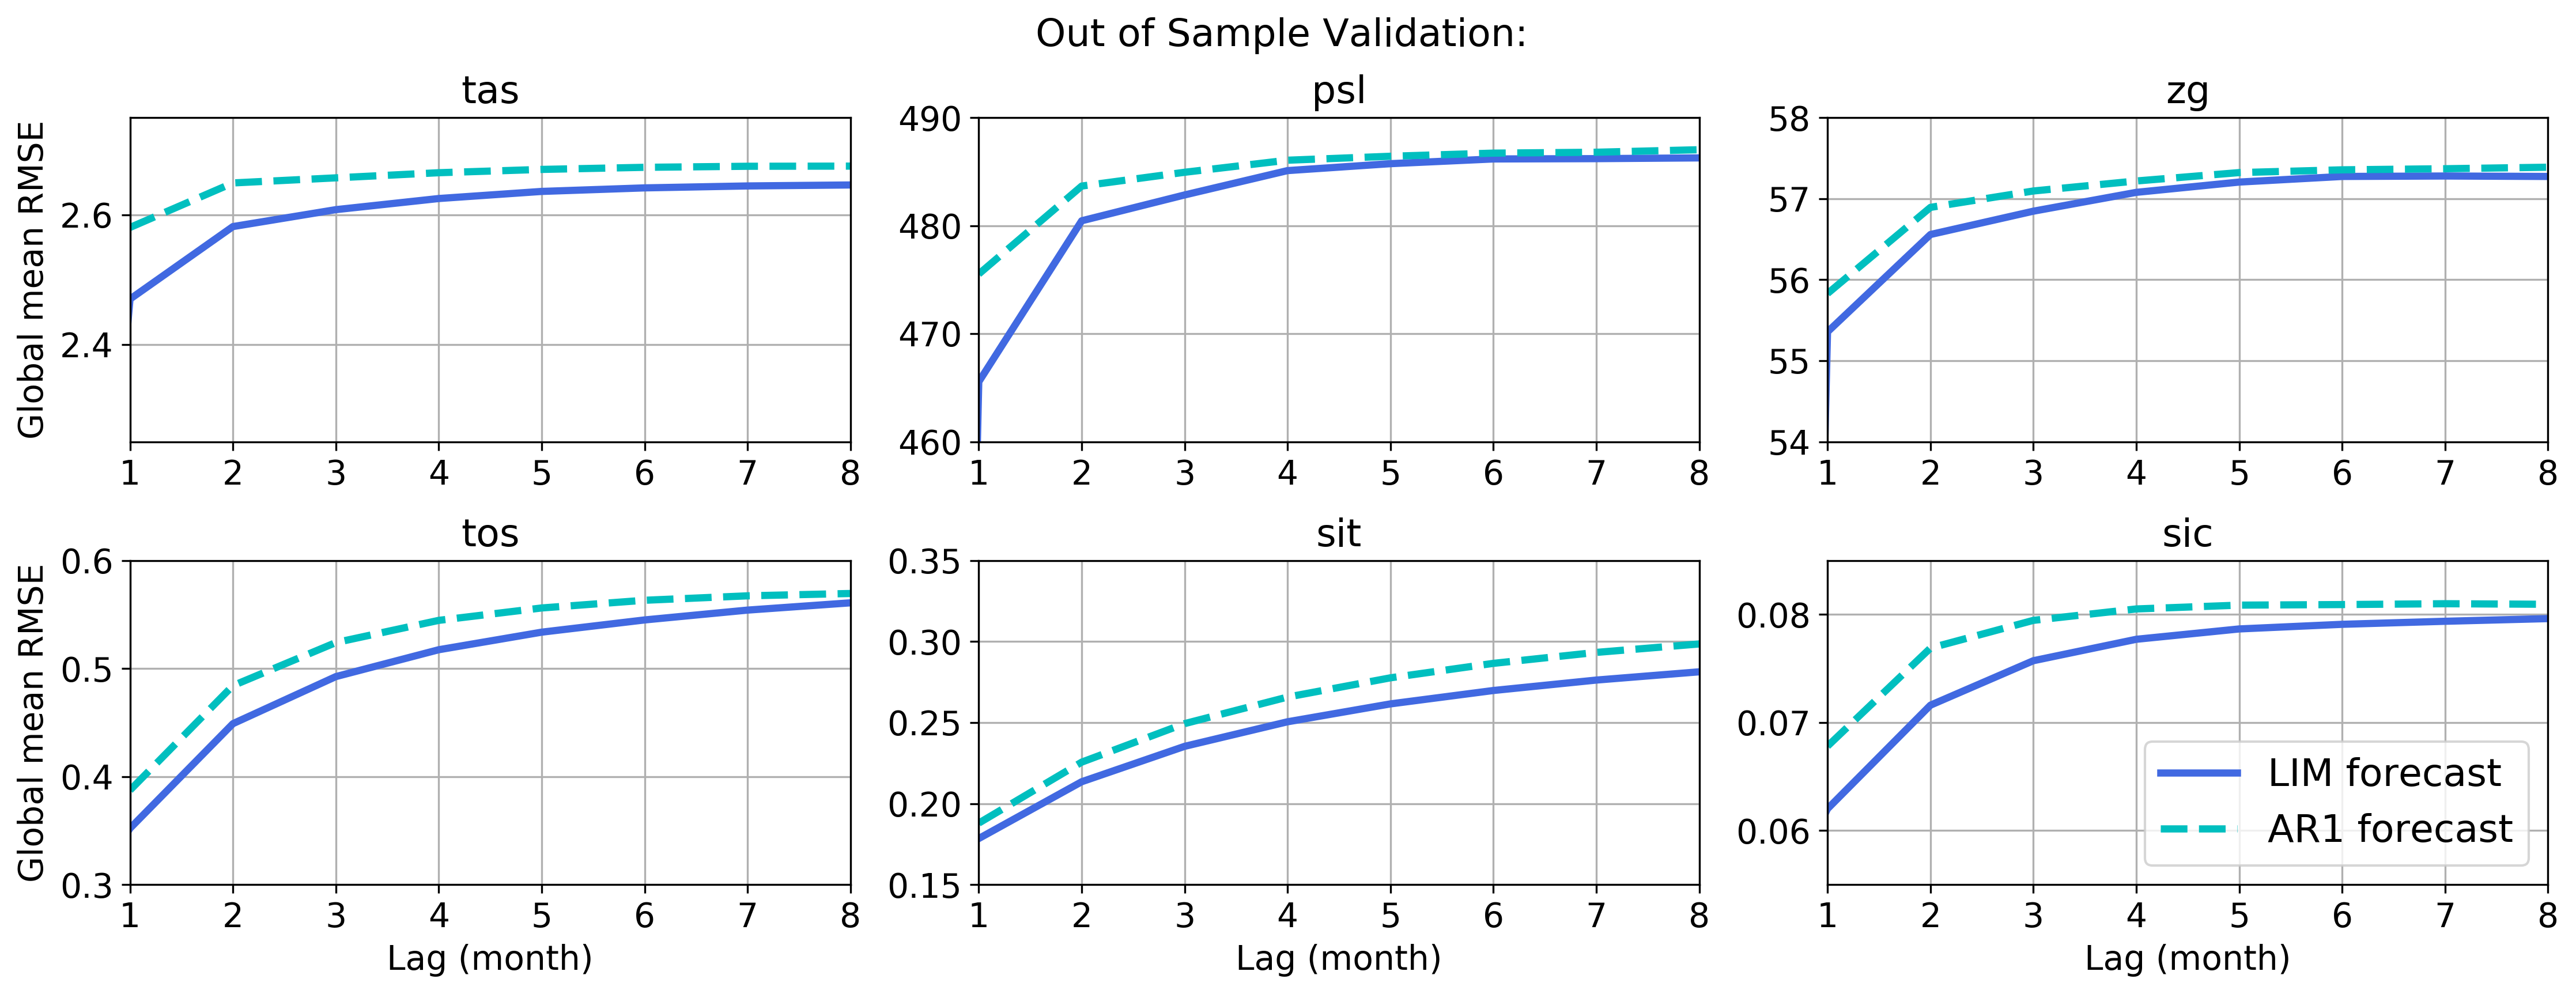

In [14]:
vmin = [2.25,460,54,0.3,0.15, 0.055]
vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_lme['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_lme['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## LE 2007--2082 performance: 

Text(0.5,1,'Sea-ice Concentration')

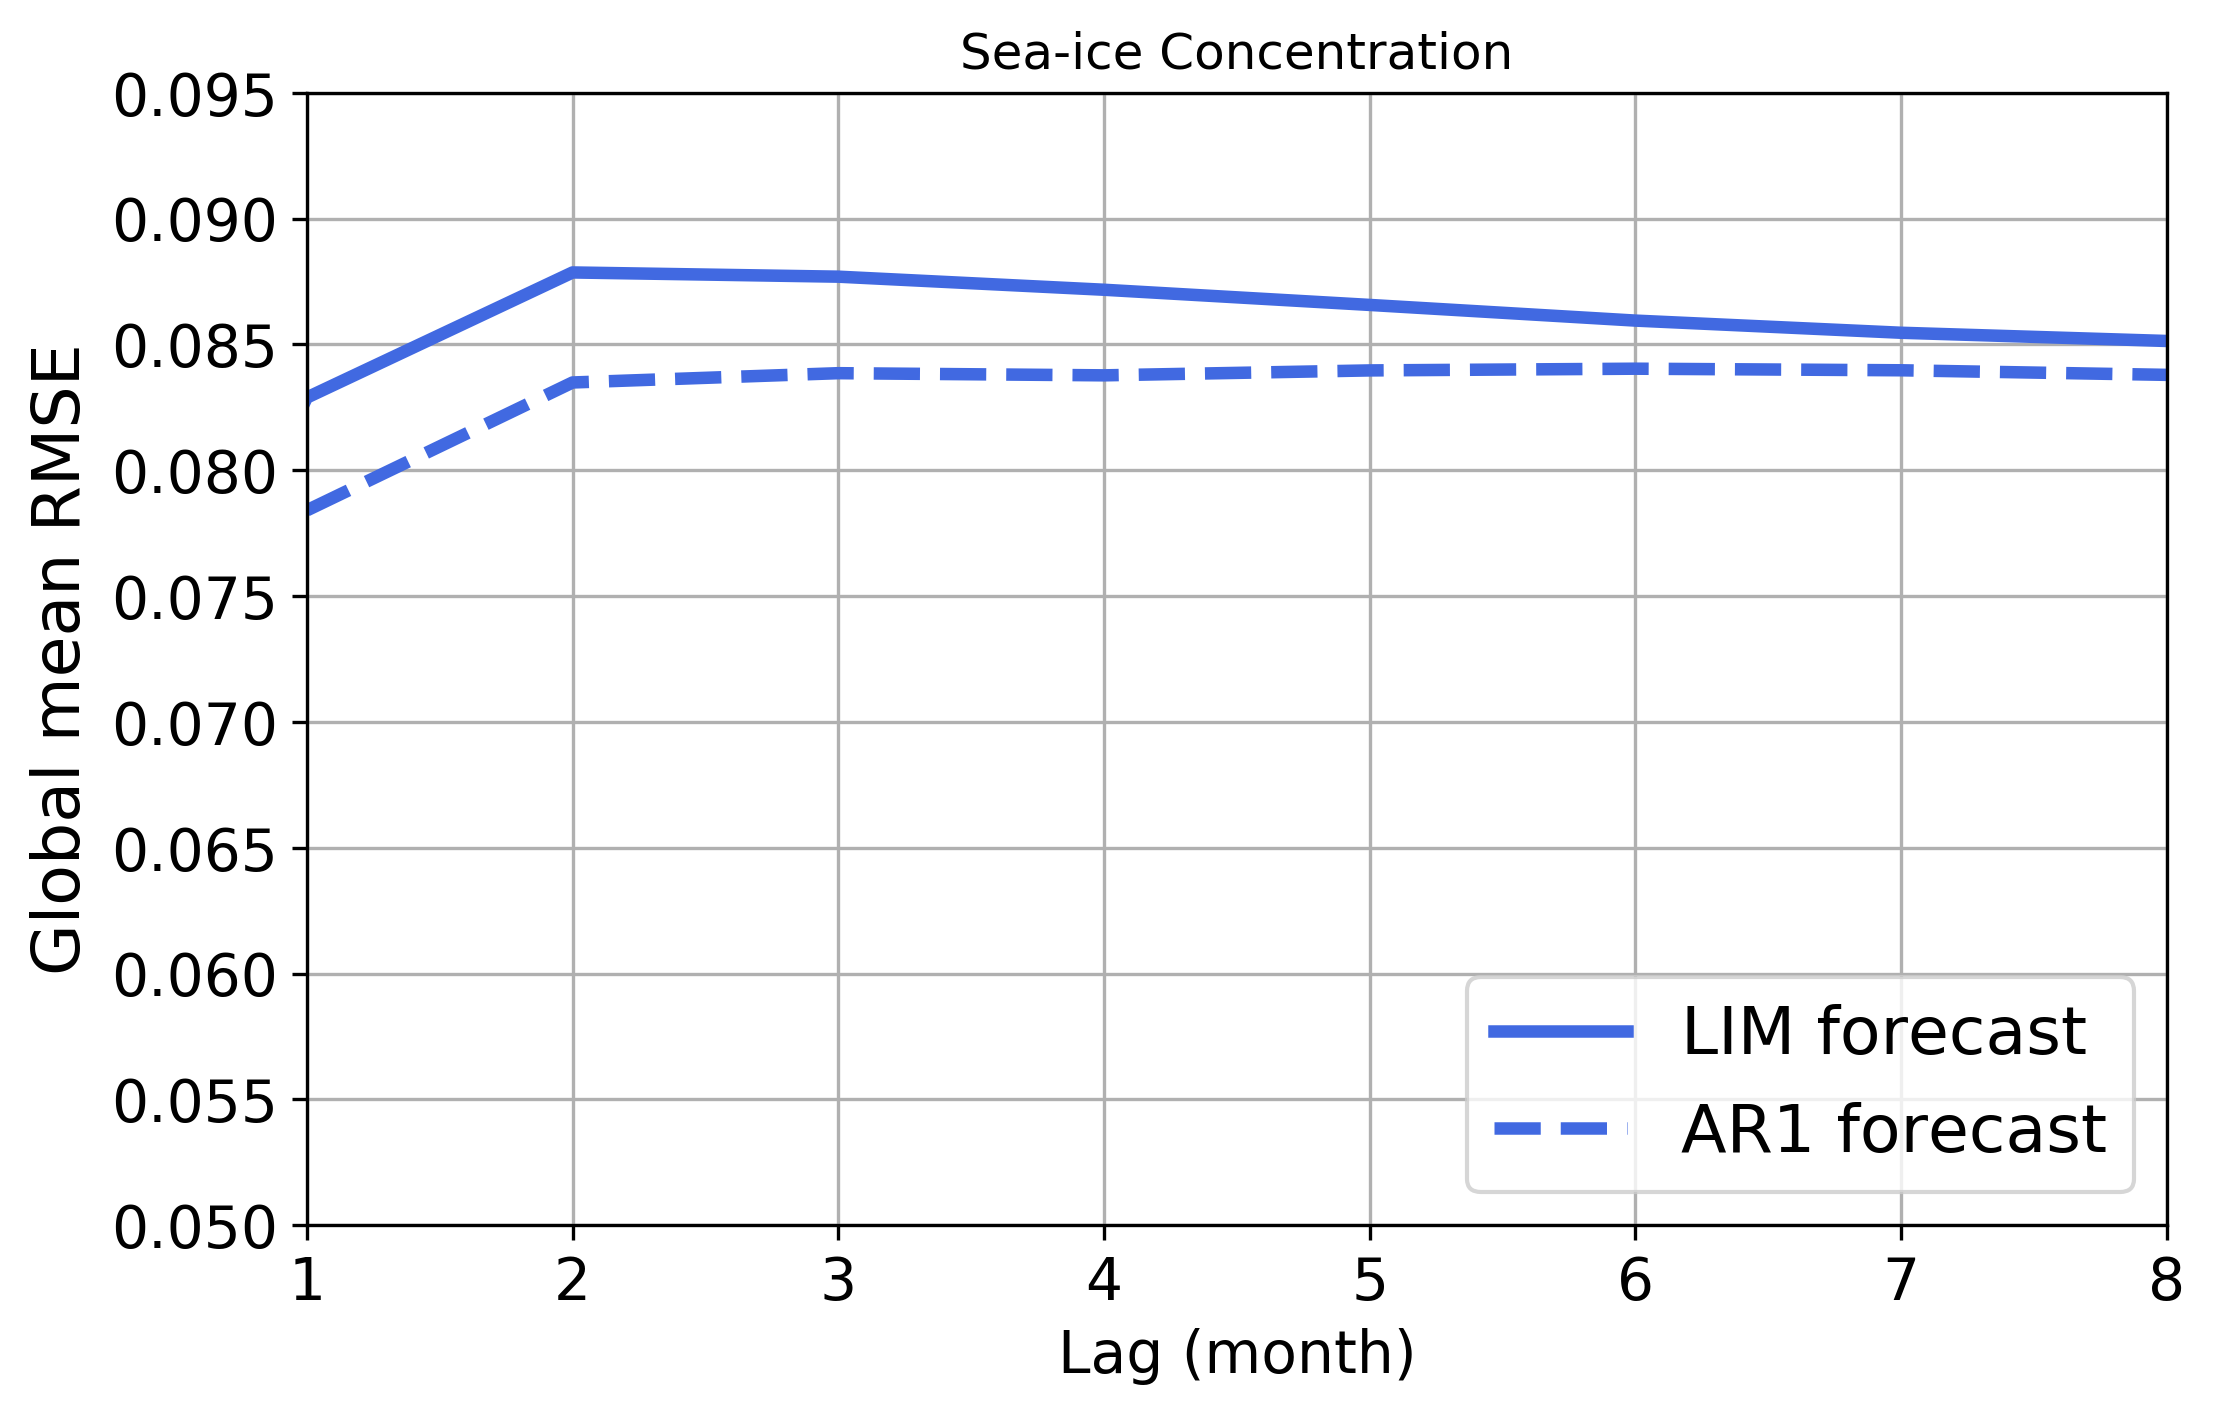

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast', color='royalblue', linewidth=3, linestyle='--')

plt.ylim(0.05,0.095)
plt.xlim(1,8)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

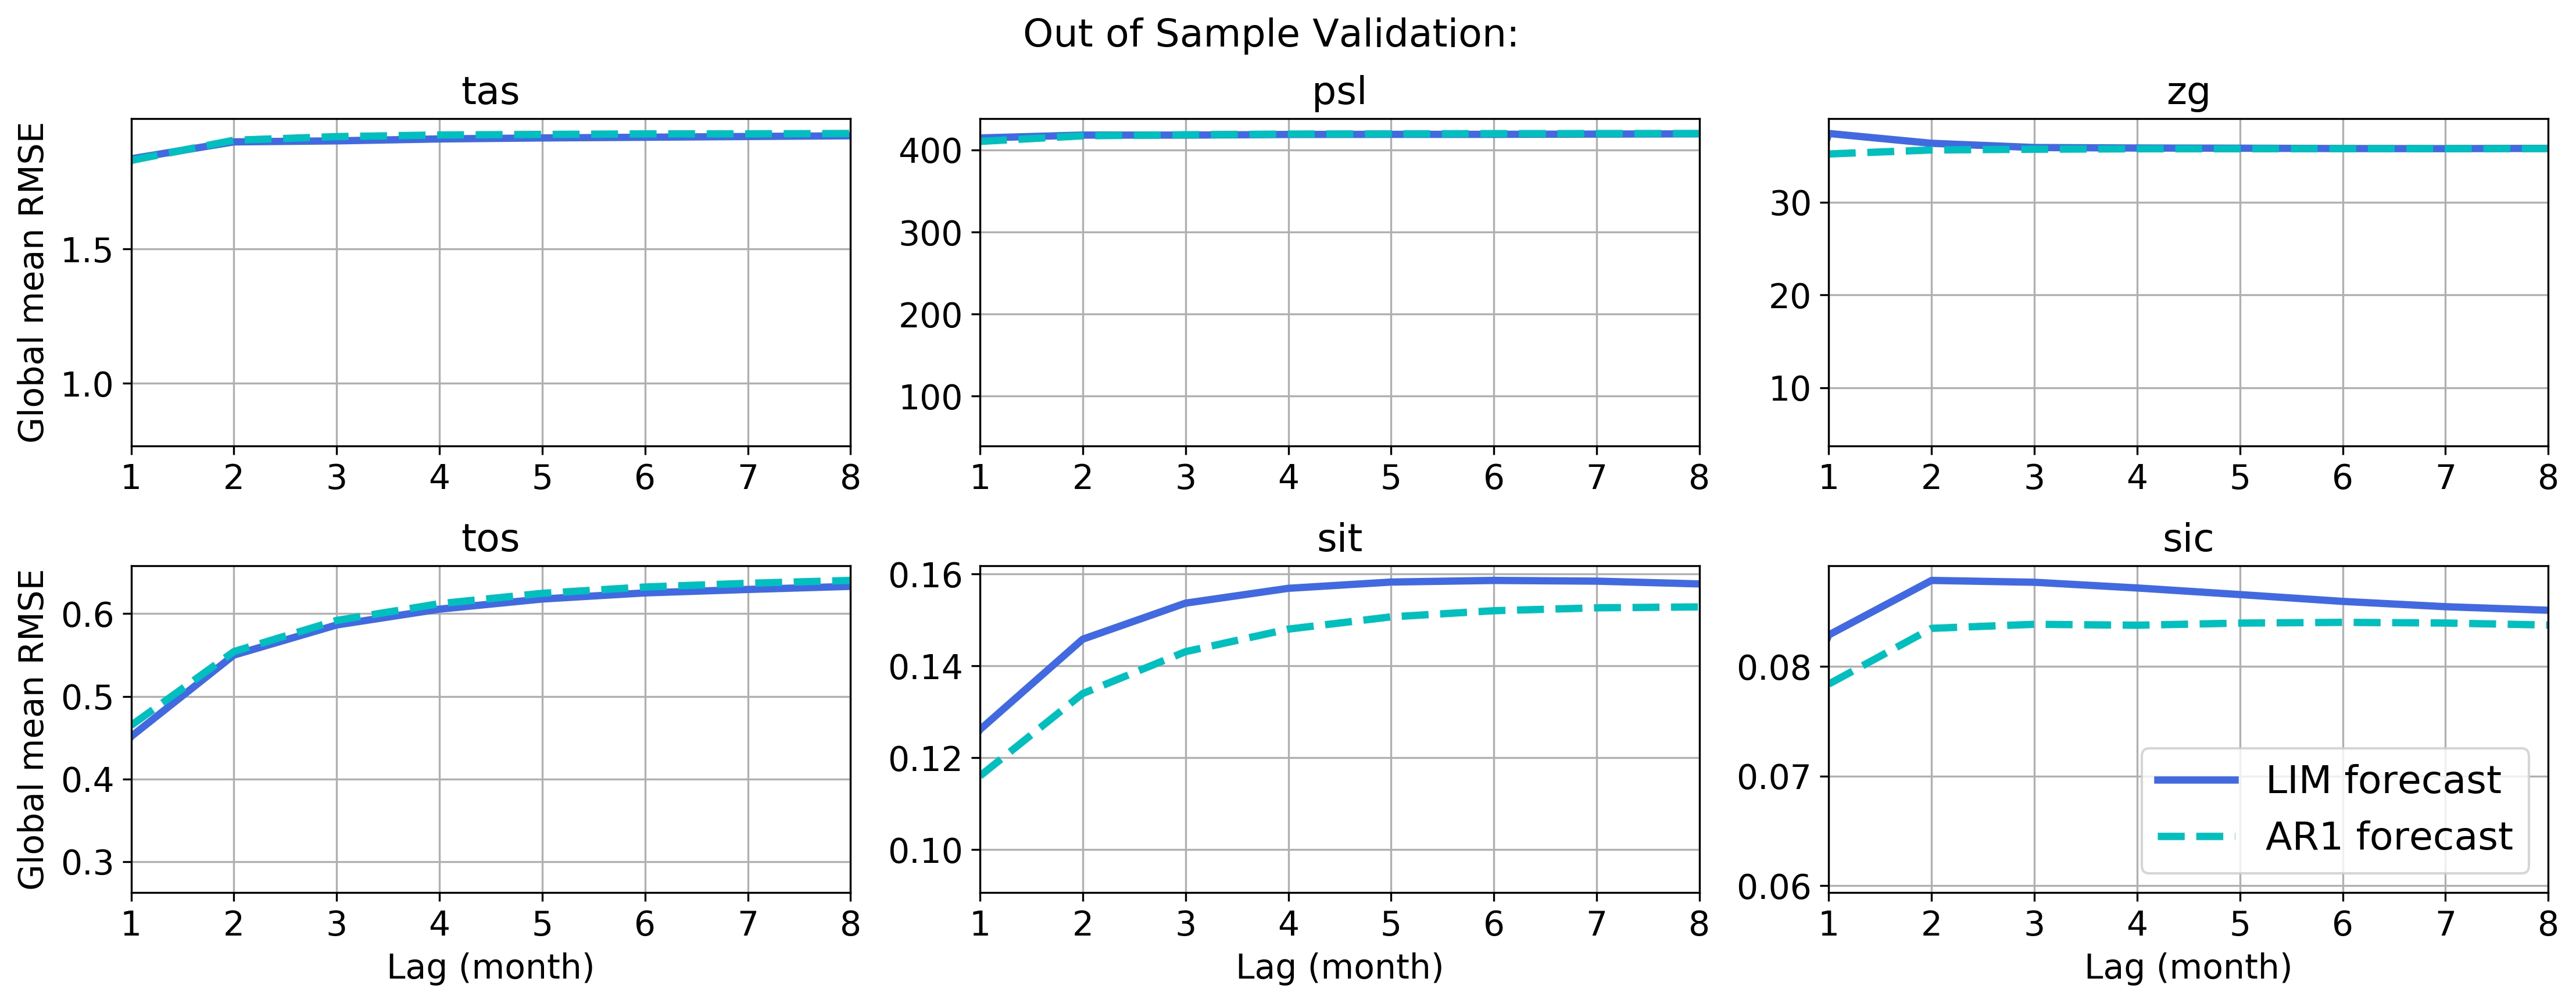

In [18]:
# vmin = [2.25,460,54,0.3,0.15, 0.055]
# vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
#    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [138]:
%run run_forecast_LME_crossmodel_validation_122021.py

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tas_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated psl from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/psl_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated zg from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/zg_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated tos from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tos_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated sit from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/sit_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated sic 

FileNotFoundError: [Errno 2] No such file or directory: b'/home/disk/kalman2/mkb22/LMR/data/model/cmip6-mpi-esm1-2-historical/zg_500hPa_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_regridlme_185001-201412_noplev.nc'